Before you turn this assignment in, make sure everything runs as expected by going to the menubar and running:

Kernel
 Restart & Run All

In [1]:
from elasticsearch import Elasticsearch, helpers
import os
import json
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import math
import numpy as np
import pandas as pd
import pytrec_eval
import matplotlib.pyplot as plt
from elasticsearch.helpers import bulk
from zipfile import ZipFile
from typing import Dict, List, Optional
from collections import defaultdict
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from krovetzstemmer import Stemmer
from nltk.stem import WordNetLemmatizer
from concurrent.futures import ThreadPoolExecutor
from multiprocessing import Pool
from gensim import corpora
from gensim.models import LsiModel
from gensim.models import TfidfModel
import gensim.downloader as api
from functools import lru_cache
from sklearn.metrics.pairwise import cosine_similarity
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import ndcg_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from sentence_transformers import InputExample
from torch.utils.data import DataLoader
from sentence_transformers.datasets import SentenceLabelDataset

In [2]:
studentnumber1 = "14646161" # Nora
studentnumber2 = "14622556" # Abe

In [3]:
def load_queries_dict(query_file):
    """
    Load queries from a TSV file.
    
    Args:
        query_file: Path to the TSV file containing queries.

    Returns:
        A dictionary with query_id and text.
    """
    # Load queries from TSV
    queries_df = pd.read_csv(query_file, sep='\t', names=["query_id", "query_string"])
    queries_dict = dict(zip(queries_df["query_id"], queries_df["query_string"]))
    
    return queries_dict

def load_qrels_dict(qrels_file):
    """
    Load relevance judgments (qrels) from a file in a dictionary.
    
    Args:
        qrels_file: Path to the file containing qrels.

    Returns:
        A dictionary with query_id as keys and another dictionary of doc_id and relevance as values.
    """
    qrels_df = pd.read_csv(qrels_file, sep=' ', names=["query_id", "Q0", "doc_id", "relevance"])
    qrels_df = qrels_df.drop(columns=["Q0"])
    
    qrels_dict = defaultdict(lambda: defaultdict(int))
    for _, row in qrels_df.iterrows():
        qrels_dict[row['query_id']][row['doc_id']] = row['relevance']
    
    return qrels_dict

def load_collection_dict(collection_file):
    """
    Load the collection of documents.
    
    Args:
        collection_file: Path to the file containing the collection of documents.

    Returns:
        A dictionary with doc_id as keys and text as values.
    """
    with open(collection_file, 'r') as f:
        lines = f.readlines()

    collection_dict = {json.loads(line)['id']: json.loads(line)['contents'] for line in lines}
    
    return collection_dict

def print_first_key_and_value(dictionary) -> None:
    try:
        first_key = next(iter(dictionary))
        first_value = dictionary[first_key]
        print(f"{first_key}: {first_value}")
    except Exception as e:
        print(e)

In [4]:
lemmatizer = WordNetLemmatizer()
stemmer = Stemmer()
stop_words = set(stopwords.words('english'))
tokenizer = RegexpTokenizer(r'\b[a-zA-Z]+\b')  # Only keeps alphabetic tokens

def preprocess_texts(texts):
    with Pool() as pool:
        results = pool.map(preprocess_text, texts)
    return results

@lru_cache(maxsize=None)
def process_token(token):
    return stemmer.stem(lemmatizer.lemmatize(token))

def preprocess_text(text) -> str:
    tokens = tokenizer.tokenize(text.lower())
    processed_tokens = [
        process_token(word)
        for word in tokens
        if word not in stop_words
    ]
    return ' '.join(processed_tokens)

def preprocess_dict(dictionary):
    return {key: preprocess_text(value) for key, value in dictionary.items()}

def preprocess_dict_concurrent(dictionary):
    with ThreadPoolExecutor() as executor:
        processed_items = list(executor.map(lambda item: (item[0], preprocess_text(item[1])), dictionary.items()))
    return dict(processed_items)


In [5]:
# Load train, test, validation queries
# Load the queries in a dict with the following format: [query_id] = query_text
train_queries_dict = preprocess_dict(load_queries_dict('data/training_queries.tsv'))
test_queries_dict = preprocess_dict(load_queries_dict('data/test_queries.tsv'))
validation_queries_dict = preprocess_dict(load_queries_dict('data/validation_queries.tsv'))

print_first_key_and_value(train_queries_dict)

qid_1: hillsborough community college president


In [6]:
# Load validation and traning query relevance here using the following format:
# [query_id][passage_id] = score
train_qrel_dict = load_qrels_dict('data/training_qrels.txt')
validation_qrel_dict = load_qrels_dict('data/validation_qrels.txt')

print_first_key_and_value(train_qrel_dict)
print_first_key_and_value(validation_qrel_dict)
print(train_qrel_dict['qid_1']['pid_4']) # Should be 0
print(validation_qrel_dict['qid_5001']['pid_693445']) # Should be 1

qid_1: defaultdict(<class 'int'>, {'pid_665937': 1})
qid_5001: defaultdict(<class 'int'>, {'pid_863768': 3, 'pid_844238': 0, 'pid_339533': 0, 'pid_508620': 0, 'pid_806656': 3, 'pid_865484': 4, 'pid_586369': 0, 'pid_795188': 0, 'pid_803529': 4, 'pid_527942': 2, 'pid_462528': 0, 'pid_465360': 0, 'pid_993589': 0, 'pid_995506': 4, 'pid_807814': 0, 'pid_990839': 1, 'pid_192087': 0, 'pid_645799': 0, 'pid_440239': 0, 'pid_348239': 0, 'pid_616122': 0, 'pid_576529': 0, 'pid_872768': 2, 'pid_232764': 0, 'pid_661954': 2, 'pid_738871': 3, 'pid_786841': 3, 'pid_381839': 0, 'pid_798620': 3, 'pid_324061': 0, 'pid_856900': 0, 'pid_477088': 3, 'pid_989364': 2, 'pid_897041': 3, 'pid_643987': 0, 'pid_964548': 0, 'pid_778078': 0, 'pid_190059': 0, 'pid_267075': 1, 'pid_865476': 2, 'pid_164761': 0, 'pid_607374': 0, 'pid_36482': 0, 'pid_41431': 1, 'pid_180073': 3, 'pid_689715': 2, 'pid_411844': 1, 'pid_156270': 1, 'pid_109766': 0, 'pid_266441': 4, 'pid_542451': 1, 'pid_250556': 0, 'pid_125480': 1, 'pid_41181

In [7]:
# Load collection
# Load the collection in a dict with the following format: [passage_id] = passage_text
collection_dict = preprocess_dict(load_collection_dict('data/collection.jsonl'))

print_first_key_and_value(collection_dict)

pid_1: mobile app book ticket use mobile


In [8]:
def write_ranking_results(ranking_results, output_file, ranking_name):
    """
    Write the ranking results to a file in the required format.

    Args:
        ranking_results: A dictionary of dictionaries, each containing:
                         - query_id: {doc_id: score}
        output_file: Path to the output file.
        ranking_name: Name of the ranking method (e.g., "TF_IDF_ranking").
    """
    with open(output_file, "w", encoding="utf-8") as f:
        for query_id, docs in ranking_results.items():
            # Sort documents by score
            sorted_docs = sorted(docs.items(), key=lambda x: x[1], reverse=True)

            for rank, (doc_id, score) in enumerate(sorted_docs[:100], start=1):
                
                # Write the results to file in the required format
                f.write('\t'.join([
                    str(query_id),  # Query ID
                    str(doc_id),    # Document ID
                    str(rank),      # Rank
                    str(score),     # Score
                    ranking_name    # Ranking method
                ]) + '\n')
                
    print(f"Produced file {output_file}")


def codalab_format(validation_output_file, test_output_file, studentnumber1, studentnumber2):
    """
    Create a Codalab submission zip file with correctly named validation and test ranking results.

    Args:
        validation_output_file: Path to the validation ranking results file.
        test_output_file: Path to the test ranking results file.
        studentnumber1: Student number.
        studentnumber2: Student name.
    """
    # Create the zip file name based on student information
    output_dir = "output"
    filename = f"{studentnumber1}_{studentnumber2}_codalab_submission.zip"

    # Ensure that the output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Full path for the zip file
    zip_file_path = os.path.join(output_dir, filename)

    # Create the zip file for submission
    with ZipFile(zip_file_path, 'w') as zipObj:
        # Rename the files according to Codalab's requirements
        zipObj.write(validation_output_file, "submission_validation.text")
        zipObj.write(test_output_file, "submission_test.text")

    print(f"Produced submission file {zip_file_path}")
    return zip_file_path

# Milestone 2: Learning-to-rank (Re-ranking)

The focus of this milestone is on re-ranking. You will use the output of first-stage retrieval models from the previous milestone and re-rank the top passages returned by them to enhance the retrieval performance. In this milestone, you will learn how to train learning-to-rank models and will get familiar with hyper-parameter tuning and feature selection concepts. In addition, you will learn how to use the existing pre-trained models for re-ranking.

Note:
1. You **must** use the **pytrec_eval** library to evaluate the models.
2. You **must** use the defined functions and data structures. You can always add more inputs and outputs to the functions.
3. Please **make sure** to follow the comments and explanations provided in the Notebook carefully. We check the comments and corresponding cells for grading. If you don't, it will make it difficult for us to evaluate your work.
4. If your code is messy or hard to follow, it will also make it hard for us to assess your work, which could lead to some point loss. Clear, well-organized code is required for a fair and efficient grading process.
5. You can pick any pre-processing libraries you wish. Just be consistent all along different stages to prevent mismatch errors.

# Training XGBoost model (67)

**Step 1:** Use ElasticSearch to get the “BM25” and “TF-IDF”  scores for train/test/validation sets. For the BM25 model use the best parameter set from the previous Milestone.  For this you will need to define 2 separate indexes using BM25 and TF-IDF as the ranking functions.(10)

**Note:** TF-IDF is not included anymore in ElasticSearch (i.e., the `classic` ranker does not exist), you will need to add the formula manually.

```json
"similarity": {
            "scripted_tfidf": {
                "type": "scripted",
                "weight_script": {
                    "source": "double idf = Math.log((field.docCount + 1.0) / (term.docFreq + 1.0)) + 1.0; return query.boost * idf;"
                },
                "script": {
                    "source": "double tf = Math.sqrt(doc.freq); double norm = 1.0 / Math.sqrt(doc.length); return weight * tf * norm;"
                }
            }
        }
    },
    "mappings": {
        "properties": {
            "content": {
                "type": "text",
                "similarity": "scripted_tfidf"
            }
        }
    }
}


In [9]:
# Running in a Docker container
es = Elasticsearch(
    hosts=["http://localhost:9200"],
    max_retries=3,
    retry_on_timeout=True
)

assert es.ping(), 'Docker inactive'

In [10]:
def create_index(index_name, index_settings, batch_size=5000):
    if not es.indices.exists(index=index_name):
        es.indices.create(index=index_name, body=index_settings)

    df_documents_amount = len(collection_dict)
    index_documents_amount = es.count(index=index_name)['count']
    print(f'Before indexing: {df_documents_amount=:_}, {index_documents_amount=:_}')

    if df_documents_amount != index_documents_amount:

        es.indices.delete(index=index_name)
        es.indices.create(index=index_name, body=index_settings)
        
        actions = [
            {
                "_index": index_name,
                "_id": doc_id,
                "_source": {
                    "doc_id": doc_id,
                    "text": text
                }
            }
            for doc_id, text in collection_dict.items()
        ]
        
        helpers.bulk(es, actions, chunk_size=batch_size)

        es.indices.refresh(index=index_name)

    index_documents_amount = es.count(index=index_name)['count']
    print(f'After indexing: {index_documents_amount=:_}')

In [11]:
# Use ES to get BM25 scores here
index_name = 'bm25_index'

index_settings = {
    "settings": {
        "index": {
            "number_of_shards": 1,
            "number_of_replicas": 0,
            "similarity": {
                "default": {
                    "type": "BM25",
                    "k1": 0.285, # Found by hyperparameter tuning in Milestone 1
                    "b": 0.095
                }
            }
        },
        "analysis": {
            "analyzer": {
                "fulltext_analyzer": {
                    "type": "custom",
                    "tokenizer": "standard",
                    "filter": []
                }
            }
        }
    },
    "mappings": {
        "properties": {
            "content": {
                "type": "text",
                "analyzer": "fulltext_analyzer",
                "similarity": "default"
            }
        }
    }
}

create_index(index_name, index_settings, batch_size=5000)

Before indexing: df_documents_amount=1_000_000, index_documents_amount=0
After indexing: index_documents_amount=1_000_000


In [12]:
# Use ES to get TF-IDF scores here
index_name = 'tfidf_index'

index_settings = {
    "settings": {
        "index": {
            "number_of_shards": 1,
            "number_of_replicas": 0,
            "similarity": {
                "scripted_tfidf": {
                    "type": "scripted",
                    "weight_script": {
                        "source": "double idf = Math.log((field.docCount + 1.0) / (term.docFreq + 1.0)) + 1.0; return query.boost * idf;"
                    },
                    "script": {
                        "source": "double tf = Math.sqrt(doc.freq); double norm = 1.0 / Math.sqrt(doc.length); return weight * tf * norm;"
                    }
                }
            }
        },
        "analysis": {
            "analyzer": {
                "fulltext_analyzer": {
                    "type": "custom",
                    "tokenizer": "standard",
                    "filter": []
                }
            }
        }
    },
    "mappings": {
        "properties": {
            "content": {
                "type": "text",
                "analyzer": "fulltext_analyzer",
                "similarity": "scripted_tfidf"
            }
        }
    }
}

create_index(index_name, index_settings, batch_size=5000)

Before indexing: df_documents_amount=1_000_000, index_documents_amount=0
After indexing: index_documents_amount=1_000_000


In [13]:
mapping = es.indices.get_mapping(index='bm25_index')
print(mapping)

{'bm25_index': {'mappings': {'properties': {'content': {'type': 'text', 'analyzer': 'fulltext_analyzer', 'similarity': 'default'}, 'doc_id': {'type': 'text', 'fields': {'keyword': {'type': 'keyword', 'ignore_above': 256}}}, 'text': {'type': 'text', 'fields': {'keyword': {'type': 'keyword', 'ignore_above': 256}}}}}}}


In [14]:
mapping = es.indices.get_mapping(index='tfidf_index')
print(mapping)

{'tfidf_index': {'mappings': {'properties': {'content': {'type': 'text', 'analyzer': 'fulltext_analyzer', 'similarity': 'scripted_tfidf'}, 'doc_id': {'type': 'text', 'fields': {'keyword': {'type': 'keyword', 'ignore_above': 256}}}, 'text': {'type': 'text', 'fields': {'keyword': {'type': 'keyword', 'ignore_above': 256}}}}}}}


In [15]:
indices = es.cat.indices(v=True)
print(indices)

health status index       uuid                   pri rep docs.count docs.deleted store.size pri.store.size
green  open   tfidf_index dKT6wpSaTr2w04aVHI6x0Q   1   0    1000000            0    557.3mb        557.3mb
green  open   bm25_index  57_XcfGjRdKyG5VVLmSKAw   1   0    1000000            0    428.4mb        428.4mb



In [16]:
search_results = es.search(
            index='tfidf_index',
            query={'match': {'text': 'pie'}},
            size=1
        )

print(search_results)

{'took': 49, 'timed_out': False, '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0}, 'hits': {'total': {'value': 519, 'relation': 'eq'}, 'max_score': 14.429539, 'hits': [{'_index': 'tfidf_index', '_id': 'pid_436177', '_score': 14.429539, '_source': {'doc_id': 'pid_436177', 'text': 'create pie pie click chart data insert tab click pie button chart group pie pie chart type menu'}}]}}


In [17]:
search_results = es.search(
    index='bm25_index',
    query={'match': {'text': 'pie'}},
    size=1
)

print(search_results)

{'took': 17, 'timed_out': False, '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0}, 'hits': {'total': {'value': 519, 'relation': 'eq'}, 'max_score': 9.4578495, 'hits': [{'_index': 'bm25_index', '_id': 'pid_459343', '_score': 9.4578495, '_ignored': ['text.keyword'], '_source': {'doc_id': 'pid_459343', 'text': 'history pie pie around since ancient egypt first pie made early roman may learned greece roman must spread word pie around europe oxford english dictionary note word pie popular word century first pie recipe publish roman rye crust goat cheese honey pie early pie predominate meat pie pye pie originally appear england early twelfth century crust pie refer coffyn'}}]}}


Testing the functions:

In [18]:
def ranking_via_index(index_name, queries_dict, top_n=100) -> dict:
    """
    Perform ranking for the given queries using the specified Elasticsearch index via multi-search.

    Args:
        index_name: Name of the index.
        queries_dict: A dictionary with the 'query_id' as keys and the 'query_string' as values.
        top_n: Number of top documents to return for each query.

    Returns:
        A dictionary in the format {query_id: {doc_id: score}}
    """
    ranking_results = {}

    msearch_queries = []
    for query_id, query_string in queries_dict.items():
        msearch_queries.append({"index": index_name})
        msearch_queries.append({"query": {"match": {"text": query_string}}, "size": top_n})

    response = es.msearch(body=msearch_queries)

    for idx, query_id in enumerate(queries_dict.keys()):
        query_results = response['responses'][idx]

        top_docs = {
            hit["_id"]: hit["_score"]
            for hit in query_results["hits"]["hits"]
        } if "hits" in query_results["hits"] and query_results["hits"]["hits"] else {}

        # If fewer than top_n results, fill the remaining with match_all results
        if len(top_docs) < top_n:
            match_all_results = es.search(
                index=index_name,
                query={"match_all": {}},
                size=top_n
            )

            for hit in match_all_results["hits"]["hits"]:
                doc_id = hit["_id"]
                if doc_id not in top_docs:  # Avoid duplicates
                    top_docs[doc_id] = hit["_score"]

        ranking_results[query_id] = dict(list(top_docs.items())[:top_n])

    return ranking_results

In [19]:
# Copied from the starting kit
def mrr(scores, labels, k):
    # only consider the position of the first passage that hit the ground truth 
    assert len(scores) == len(labels), 'scores and labels must be the same length'
    
    reciprocal_rank = 0
    
    for q_id, p_ids in scores.items():
        
        for index, p_id in enumerate(p_ids):
            if index == k:
                break
            
            if p_id in labels[q_id]:
                # MRR is a binary IR metric. So for binary relevance judgments, 1 is relevant, while for graded relevance judgments, 2,3,4 are relevant while 0,1 are irrelevant.
                # Our validation and test sets use graded relevance judgments, so there we regard 3,4 as relevant
                if labels[q_id][p_id]>=2:
                    reciprocal_rank += 1.0 / (index+1)
                    break

    return reciprocal_rank / len(scores)


def evaluate(qrel, run, metrics=["recall_10", "recall_20", "ndcg_cut_10", "P_5", "P_20", "mrr_100"], silent=False):
    """
    Evaluate the ranking output using qrels and pytrec_eval.

    Args:
        qrel (dict): Ground truth relevance judgments. {query_id: {doc_id: relevance}}
        run (dict): Model's predictions. {query_id: {doc_id: score}}
        metrics (list): List of metrics to compute.

    Returns:
        dict: A dictionary with the computed metric values.
    """

    assert isinstance(qrel, dict), "The `qrel` parameter must be a dictionary with format {query_id: {doc_id: relevance}}."
    assert isinstance(run, dict), "The `run` parameter must be a dictionary with format {query_id: {doc_id: score}}."
    assert len(qrel) == len(run), "The `qrel` and `run` parameters must have the same number of queries."
    assert qrel and run, "qrel or run dictionary is empty. Cannot perform evaluation."
    
    filtered_metrics = [metric for metric in metrics if metric != 'mrr_100']
    
    evaluator = pytrec_eval.RelevanceEvaluator(qrel, filtered_metrics)

    results: Dict[str, Dict[str, float]] = evaluator.evaluate(run)

    assert results is not None, "No results returned from evaluation. Please check the input `qrel` and `run` formats."
    
    # Vectorized results to make it faster
    results_df = pd.DataFrame.from_dict(results, orient='index').reindex(columns=filtered_metrics).fillna(0.0)
    aggregated_results = results_df.mean().to_dict()
    
    if 'mrr_100' in metrics:
        mrr_score = mrr(run, qrel, 100)
        aggregated_results['mrr_100'] = mrr_score
            
    formatted_result = " ; ".join([f"{metric}: {aggregated_results[metric]:.4f}" for metric in aggregated_results])
    
    if not silent:
        print(formatted_result)

    return aggregated_results

In [20]:
tfidf_valid = ranking_via_index('tfidf_index', validation_queries_dict, 100)
tfidf_eval = evaluate(validation_qrel_dict, tfidf_valid)

recall_10: 0.1201 ; recall_20: 0.2079 ; ndcg_cut_10: 0.2951 ; P_5: 0.4240 ; P_20: 0.3587 ; mrr_100: 0.4417


In [21]:
bm25_valid = ranking_via_index('bm25_index', validation_queries_dict, 100)
bm25_eval = evaluate(validation_qrel_dict, bm25_valid)

recall_10: 0.1469 ; recall_20: 0.2422 ; ndcg_cut_10: 0.3555 ; P_5: 0.4720 ; P_20: 0.4047 ; mrr_100: 0.5366


**Step 2:** Create the following features for each query in the training set and the top 20 passages retrieved by the BM25 model. For test and validation queries, create these features for the top 100 passages. Store the results on a text file as you need them in the next steps. (14)

1.   LSA vectors similarity. Train an LSA model on your data and represent the queries and top documents using LSA. For this, you can use the `gensim` library. Compute the cosine similarity of LSA vectors of (q, d). (3)
2.   Word2Vec embedding similarity score. Load pre-trained word2vec embeddings from the `gensim` library. Compute the Average Word Embeddings (AWE) of each query and its top ranked documents. (3)
3.   TF-IDF similarity score. (2)
4.   BM25 similarity score. (2)
5.   Query term count. (2)
6.   Document term count. (2)




In [22]:
def write_rankings_to_file(rankings: defaultdict | dict, output_file: str) -> None:
    output_dir = 'results'
    os.makedirs(output_dir, exist_ok=True)
    file_path = os.path.join(output_dir, output_file)
    
    with open(file_path, 'w') as file:
        for query_id, doc_dict in rankings.items():
            file.write(f'Query {query_id}:\n')
            for doc_id, score in doc_dict.items():
                file.write(f'    Doc ID: {doc_id}, Score: {score}\n')
            file.write('\n')

    print(f'Results written to {file_path}')

In [23]:
def read_file_to_dict(file_name: str) -> dict:
    result_dict = {}
    with open(file_name, 'r') as file:
        current_query = None
        for line in file:
            line = line.strip()
            if line.startswith("Query"):
                current_query = line.split()[1][:-1]
                result_dict[current_query] = {}
            elif line.startswith("Doc ID"):
                parts = line.split(", ")
                doc_id = parts[0].split(": ")[1]
                score = float(parts[1].split(": ")[1])
                result_dict[current_query][doc_id] = score
                
    return result_dict

In [24]:
def bm25(queries_dict, top_n, output_file) -> Dict[str, Dict[str, float]]:
    """
    Get BM25 rankings for the given queries and save results to a file.

    Args:
        queries_dict: A dictionary with query IDs and query strings.
        top_n: Number of top documents to return for each query.
        output_file: The name of the output file where results are stored.

    Returns:
        The BM25 rankings.
    """
    bm25_rankings = ranking_via_index('bm25_index', queries_dict, top_n)
    write_rankings_to_file(bm25_rankings, output_file)
    return bm25_rankings

In [25]:
try:
    bm25_rankings_val = read_file_to_dict('results/bm25_val.txt')
    bm25_rankings_test = read_file_to_dict('results/bm25_test.txt')
    bm25_rankings_train = read_file_to_dict('results/bm25_train.txt')
except:
    bm25_rankings_val = bm25(validation_queries_dict, 100, 'bm25_val.txt')
    bm25_rankings_test = bm25(test_queries_dict, 100, 'bm25_test.txt')
    bm25_rankings_train = bm25(train_queries_dict, 20, 'bm25_train.txt')

In [26]:
print(bm25_rankings_val)

{'qid_5001': {'pid_803529': 26.87736, 'pid_897041': 25.629845, 'pid_486720': 25.57388, 'pid_156270': 25.408318, 'pid_121656': 25.393167, 'pid_403245': 24.978554, 'pid_41431': 24.751856, 'pid_78539': 24.7295, 'pid_866267': 24.632645, 'pid_782128': 24.614971, 'pid_57109': 24.519287, 'pid_114873': 24.490858, 'pid_242669': 24.425192, 'pid_693445': 24.147312, 'pid_865476': 24.069635, 'pid_411844': 24.02193, 'pid_872768': 23.953535, 'pid_63062': 23.844261, 'pid_681173': 23.719515, 'pid_527942': 23.707502, 'pid_303596': 23.633621, 'pid_462528': 23.510489, 'pid_374271': 23.487566, 'pid_432231': 23.463741, 'pid_542451': 23.425474, 'pid_786841': 23.410002, 'pid_474147': 23.34832, 'pid_125480': 23.3176, 'pid_2368': 23.195526, 'pid_990839': 23.134968, 'pid_801365': 22.836855, 'pid_320178': 22.576632, 'pid_689385': 22.546328, 'pid_508620': 21.858503, 'pid_643987': 21.83903, 'pid_39476': 21.362095, 'pid_190059': 21.3479, 'pid_576529': 21.212173, 'pid_166933': 21.169329, 'pid_537870': 21.059473, 'pid

In [27]:
print(bm25_rankings_test['qid_5283'])

{'pid_117266': 12.280257, 'pid_918825': 12.155283, 'pid_753852': 12.030976, 'pid_642308': 12.01893, 'pid_999404': 12.016524, 'pid_59615': 12.001927, 'pid_958055': 11.9947, 'pid_586770': 11.942802, 'pid_864522': 11.94198, 'pid_777894': 11.73322, 'pid_405569': 11.69874, 'pid_676474': 11.678431, 'pid_5532': 11.672373, 'pid_908844': 11.655184, 'pid_733135': 11.648991, 'pid_96328': 11.567174, 'pid_336586': 11.556955, 'pid_871699': 11.466952, 'pid_468556': 11.465498, 'pid_212913': 11.453239, 'pid_767653': 11.409626, 'pid_283946': 11.284936, 'pid_156569': 11.209551, 'pid_91248': 11.209067, 'pid_231672': 11.193165, 'pid_653920': 11.188173, 'pid_617972': 11.160589, 'pid_791179': 11.154905, 'pid_617982': 11.140361, 'pid_505240': 11.105911, 'pid_568500': 11.049002, 'pid_412910': 11.044501, 'pid_713034': 10.973118, 'pid_646739': 10.937847, 'pid_509757': 10.905163, 'pid_338983': 10.902853, 'pid_579502': 10.868131, 'pid_723848': 10.868131, 'pid_702133': 10.85694, 'pid_134695': 10.811132, 'pid_697133

In [28]:
for query in bm25_rankings_val:
    assert len(bm25_rankings_val[query]) == 100, f"doc_count of {query} is {len(bm25_rankings_val[query])}"

In [ ]:
bm25_eval = evaluate(validation_qrel_dict, bm25_rankings_val)

recall_10: 0.1475 ; recall_20: 0.2415 ; ndcg_cut_10: 0.3565 ; P_5: 0.4693 ; P_20: 0.4043 ; mrr_100: 0.5367


recall_10: 0.1831 ; recall_20: 0.3048 ; ndcg_cut_10: 0.4641 ; P_5: 0.5840 ; P_20: 0.4903 ; mrr_100: 0.6242

In [30]:
def tfidf(queries_dict, bm25_rankings, output_file) -> Dict[str, Dict[str, float]]:
    """
    Perform TF-IDF ranking for the given queries and save results to a file.

    Args:
        queries_dict: A dictionary with query IDs and query strings.
        bm25_rankings: A dictionary with query IDs and corresponding BM25-ranked documents.
        output_file: The name of the output file where results are stored.

    Returns:
        A dictionary in the format {query_id: {doc_id: score}} for TF-IDF rankings.
    """
    tfidf_rankings = {}

    msearch_queries = []
    for query_id, query_string in queries_dict.items():
        doc_ids = list(bm25_rankings[query_id].keys())

        assert len(doc_ids) in [20, 100, 200], f'bm25 rankings should have top_n documents per query. Query {query_id} only has {len(doc_ids)} documents'

        msearch_queries.append({"index": 'tfidf_index'})
        msearch_queries.append({
            "query": {
                "bool": {
                    "filter": [{"terms": {"_id": doc_ids}}],
                    "must": [{"match": {"text": query_string}}]
                }
            },
            "_source": ["_id", "_score"],
            "size": len(doc_ids)
        })

    response = es.msearch(body=msearch_queries)

    # Process the responses and ensure tfidf_rankings matches bm25_rankings
    for idx, query_id in enumerate(queries_dict.keys()):
        query_results = response['responses'][idx]
        
        top_docs_and_scores = {
            hit["_id"]: hit["_score"]
            for hit in query_results["hits"]["hits"]
        } if "hits" in query_results["hits"] and query_results["hits"]["hits"] else {}

        tfidf_rankings[query_id] = {
            doc_id: top_docs_and_scores.get(doc_id, 0)  # Default score is 0 if not found
            for doc_id in bm25_rankings[query_id].keys()
        }

    write_rankings_to_file(tfidf_rankings, output_file)
    
    return tfidf_rankings


In [31]:
try:
    tfidf_rankings_val = read_file_to_dict('results/tfidf_val.txt')
    tfidf_rankings_test = read_file_to_dict('results/tfidf_test.txt')
    tfidf_rankings_train = read_file_to_dict('results/tfidf_train.txt')
except:
    tfidf_rankings_val = tfidf(validation_queries_dict, bm25_rankings_val, 'tfidf_val.txt')
    tfidf_rankings_test = tfidf(test_queries_dict, bm25_rankings_test, 'tfidf_test.txt')
    tfidf_rankings_train = tfidf(train_queries_dict, bm25_rankings_train, 'tfidf_train.txt')

In [32]:
for query in tfidf_rankings_val:
    assert len(tfidf_rankings_val[query]) == 100, f"doc_count of {query} is {len(tfidf_rankings_val[query])}"
    
for query_id in bm25_rankings_val.keys():
        bm25_doc_ids = set(bm25_rankings_val[query_id].keys())
        tfidf_doc_ids = set(tfidf_rankings_val.get(query_id, {}).keys())
        assert bm25_doc_ids == tfidf_doc_ids, f"Document IDs mismatch for query '{query_id}': BM25 IDs: {bm25_doc_ids}, TF-IDF IDs: {tfidf_doc_ids}"

In [33]:
tfidf_eval = evaluate(validation_qrel_dict, tfidf_rankings_val)

recall_10: 0.1205 ; recall_20: 0.2109 ; ndcg_cut_10: 0.2964 ; P_5: 0.4240 ; P_20: 0.3637 ; mrr_100: 0.5367


The scores of tfidf_eval changed because we now take the tfidf of only the top_n documents from the bm25.

In [34]:
def build_lsa_vector(lsa_representation, num_topics):
    """Build a full LSA vector from the sparse LSA representation, ensuring all topics are included."""
    vec = np.zeros(num_topics)
    for topic_id, weight in lsa_representation:
        if topic_id < num_topics:
            vec[topic_id] = weight
    return vec

def LSA(queries_dict, bm25_rankings, output_file, num_topics=100) -> Dict[str, Dict[str, float]]:
    print('Tokenizing documents and queries...')
    
    doc_ids = []
    for query_id in queries_dict.keys():
        query_doc_ids = list(bm25_rankings[query_id].keys())
        assert len(query_doc_ids) in [20, 100, 200], f'bm25 rankings should have top_n documents per query. Query {query_id} only has {len(query_doc_ids)} documents'
        doc_ids.extend(query_doc_ids)
        
    documents: List[str] = [collection_dict[doc_id] for doc_id in doc_ids]
    tokenized_documents = [doc_text.split() for doc_text in documents]
    
    doc_id_to_index = {doc_id: index for index, doc_id in enumerate(doc_ids)}

    tokenized_queries = [query.split() for query in queries_dict.values()]

    print('Creating corpora Dictionary...')
    dictionary = corpora.Dictionary(tokenized_documents + tokenized_queries)
        
    corpus_bow = [dictionary.doc2bow(doc) for doc in tokenized_documents]
    query_bow = [dictionary.doc2bow(query) for query in tokenized_queries]

    print("Training TF-IDF model...")
    tfidf_model = TfidfModel(corpus_bow)

    corpus_tfidf = tfidf_model[corpus_bow]
    queries_tfidf = tfidf_model[query_bow]

    print(f"Training LSA model with {num_topics} topics...")
    lsa_model = LsiModel(corpus_tfidf, id2word=dictionary, num_topics=num_topics)

    # Create document vectors in LSA space while maintaining original order
    print("Creating LSA vectors...")
    docs_lsa = list(lsa_model[corpus_tfidf])
    queries_lsa = list(lsa_model[queries_tfidf])

    print("Computing similarities and creating rankings...")

    lsa_rankings = defaultdict(lambda: defaultdict(float))

    # Vectorize the similarity computation
    for i, query_id in enumerate(queries_dict.keys()):
        query_lsa = queries_lsa[i]
        query_lsa_vec = build_lsa_vector(query_lsa, num_topics)
        query_lsa_vec = np.array([query_lsa_vec])

        doc_ids_for_query = list(bm25_rankings[query_id].keys())
        doc_lsa_vecs = np.vstack([build_lsa_vector(docs_lsa[doc_id_to_index[doc_id]], num_topics) for doc_id in doc_ids_for_query])

        similarity_scores = cosine_similarity(query_lsa_vec, doc_lsa_vecs)[0]  # shape: (n_docs,)

        for j, doc_id in enumerate(doc_ids_for_query):
            lsa_rankings[query_id][doc_id] = float(similarity_scores[j])
        
        sorted_docs = sorted(lsa_rankings[query_id].items(), key=lambda item: item[1], reverse=True)
        lsa_rankings[query_id] = defaultdict(float, sorted_docs)

    write_rankings_to_file(lsa_rankings, output_file)

    return dict(lsa_rankings)


In [35]:
try:
    lsa_rankings_val = read_file_to_dict('results/lsa_val.txt')
    lsa_rankings_test = read_file_to_dict('results/lsa_test.txt')
    lsa_rankings_train = read_file_to_dict('results/lsa_train.txt')
except:
    lsa_rankings_val = LSA(validation_queries_dict, bm25_rankings_val, 'lsa_val.txt', 200)
    lsa_rankings_test = LSA(test_queries_dict, bm25_rankings_test, 'lsa_test.txt', 200)
    lsa_rankings_train = LSA(train_queries_dict, bm25_rankings_train, 'lsa_train.txt', 200)
    
# 1000 topics takes around 9.5 minutes in total

In [36]:
for query in lsa_rankings_val:
    assert len(lsa_rankings_val[query]) == 100, f"doc_count of {query} is {len(lsa_rankings_val[query])}"
    
for query_id in bm25_rankings_val.keys():
        bm25_doc_ids = set(bm25_rankings_val[query_id].keys())
        lsa_doc_ids = set(lsa_rankings_val.get(query_id, {}).keys())

        assert bm25_doc_ids == lsa_doc_ids, f"Document IDs mismatch for query '{query_id}'"

In [37]:
lsa_eval = evaluate(validation_qrel_dict, lsa_rankings_val)

recall_10: 0.0994 ; recall_20: 0.1790 ; ndcg_cut_10: 0.2432 ; P_5: 0.3507 ; P_20: 0.3243 ; mrr_100: 0.3589


In [38]:
# Caching word embeddings at the word level
@lru_cache(maxsize=None)
def get_word_embedding(word: str, model) -> Optional[np.ndarray]:
    """Retrieve the embedding for a single word, with caching."""
    if word in model:
        embedding: np.ndarray = model[word]
        return embedding
    
    return None  # Return None if the word is not in the vocabulary of the model

# Caching if the document has been seen before
@lru_cache(maxsize=None)
def get_average_word_embeddings(words: list[str], model) -> np.ndarray:
    """Compute the average word embedding for a list of words, using cached word embeddings."""
    valid_embeddings: list[np.ndarray] = [get_word_embedding(word, model) for word in words if get_word_embedding(word, model) is not None]
    
    if valid_embeddings:
        return np.mean(valid_embeddings, axis=0)
    
    return np.zeros(model.vector_size)

def W2V(rankings_dict, queries_dict, model, output_file):
    """Compute W2V for queries and their top-ranked documents, vectorized for faster similarity computation."""
    w2v_rankings = defaultdict(lambda: defaultdict(float))

    for query_id, top_docs in rankings_dict.items():
        query_text = queries_dict[query_id]

        query_embeddings = get_average_word_embeddings(query_text, model)
        query_embeddings = np.array([query_embeddings])

        assert query_embeddings.shape == (1, model.vector_size), f"Query embeddings shape mismatch: {query_embeddings.shape}"

        doc_ids_for_query = list(top_docs.keys())
        doc_embeddings = np.vstack([get_average_word_embeddings(collection_dict[doc_id], model) for doc_id in doc_ids_for_query])

        assert doc_embeddings.shape == (len(doc_ids_for_query), model.vector_size), f"Document embeddings shape mismatch: {doc_embeddings.shape}"

        # Compute cosine similarity between the query and all document embeddings at once
        similarity_scores = cosine_similarity(query_embeddings, doc_embeddings)[0]  # shape: (n_docs,)

        # Store the similarity scores for each document
        for i, doc_id in enumerate(doc_ids_for_query):
            w2v_rankings[query_id][doc_id] = float(similarity_scores[i])
            
    write_rankings_to_file(w2v_rankings, output_file)

    return w2v_rankings


In [39]:
# Load pre-trained Google News Word2Vec model (300 dimensions)
try:
    googleNews_model
except:
    print("Loading pre-trained Word2Vec Google News 300 model...")
    googleNews_model = api.load("word2vec-google-news-300")

Loading pre-trained Word2Vec Google News 300 model...


In [40]:
# Load pre-trained Glove Word2Vec model (300 dimensions)
try:
    glove_model
except:
    # print("Loading pre-trained Word2Vec Glove 300 model...")
    # glove_model = api.load("glove-wiki-gigaword-300")
    pass

In [41]:
# Load pre-trained FastText Word2Vec model (300 dimensions)
try:
    fasttext_model
except:
    # print("Loading pre-trained Word2Vec FastText 300 model...")
    # fasttext_model = api.load("fasttext-wiki-news-subwords-300")
    pass

In [42]:
w2v_rankings_val_google = W2V(bm25_rankings_val, validation_queries_dict, googleNews_model, 'w2v_val_google.txt')
# w2v_rankings_val_glove = W2V(bm25_rankings_val, validation_queries_dict, glove_model, 'w2v_val_glove.txt')
# w2v_rankings_val_fasttext = W2V(bm25_rankings_val, validation_queries_dict, fasttext_model, 'w2v_val_fasttext.txt')

Results written to results\w2v_val_google.txt


In [43]:
print('GOOGLE NEWS')
w2v_eval_google = evaluate(validation_qrel_dict, w2v_rankings_val_google)
# print('-' * 100)
# print('GLOVE')
# w2v_eval_glove = evaluate(validation_qrel_dict, w2v_rankings_val_glove)
# print('-' * 100)
# print('FASTTEXT')
# w2v_eval_fasttext = evaluate(validation_qrel_dict, w2v_rankings_val_fasttext)

GOOGLE NEWS
recall_10: 0.0843 ; recall_20: 0.1527 ; ndcg_cut_10: 0.1876 ; P_5: 0.2680 ; P_20: 0.2710 ; mrr_100: 0.5367


We choose to use the Google News 300 model, because it scores the best on most metrics

In [44]:
try:
    w2v_rankings_val = read_file_to_dict('results/w2v_val.txt')
    w2v_rankings_test = read_file_to_dict('results/w2v_test.txt')
    w2v_rankings_train = read_file_to_dict('results/w2v_train.txt')
except:    
    w2v_rankings_val = W2V(bm25_rankings_val, validation_queries_dict, googleNews_model, 'w2v_val.txt')
    w2v_rankings_test = W2V(bm25_rankings_test, test_queries_dict, googleNews_model, 'w2v_test.txt')
    w2v_rankings_train = W2V(bm25_rankings_train, train_queries_dict, googleNews_model, 'w2v_train.txt')

In [45]:
for query in w2v_rankings_val:
    assert len(w2v_rankings_val[query]) == 100, f"doc_count of {query} is {len(w2v_rankings_val[query])}"
    
for query_id in bm25_rankings_val.keys():
        bm25_doc_ids = set(bm25_rankings_val[query_id].keys())
        w2v_doc_ids = set(w2v_rankings_val.get(query_id, {}).keys())

        assert bm25_doc_ids == w2v_doc_ids, f"Document IDs mismatch for query '{query_id}'"

In [46]:
w2v_eval = evaluate(validation_qrel_dict, w2v_rankings_val)

recall_10: 0.0843 ; recall_20: 0.1527 ; ndcg_cut_10: 0.1876 ; P_5: 0.2680 ; P_20: 0.2710 ; mrr_100: 0.5367


In [47]:
def query_terms_count(bm25_rankings, queries_dict: Dict[str, str], output_file):
    query_terms_count = defaultdict(int)
    
    for query_id in bm25_rankings.keys():
        query_terms = queries_dict[query_id].split()
        query_terms_count[query_id] = len(query_terms)
    
    output_dir = 'results'
    os.makedirs(output_dir, exist_ok=True)
    file_path = os.path.join(output_dir, output_file)
    
    with open(file_path, 'w') as file:
        for query_id, term_count in query_terms_count.items():
            file.write(f'Query {query_id}:\n')
            file.write(f'    Term_count: {term_count}\n')
            file.write('\n')

    print(f'Results written to {file_path}')
    
    return query_terms_count  # The amount of terms in the query, not the length of the string

In [48]:
query_terms_count_val = query_terms_count(bm25_rankings_val, validation_queries_dict, 'query_terms_count_val.txt')
query_terms_count_test = query_terms_count(bm25_rankings_test, test_queries_dict, 'query_terms_count_test.txt')
query_terms_count_train = query_terms_count(bm25_rankings_train, train_queries_dict, 'query_terms_count_train.txt')

Results written to results\query_terms_count_val.txt
Results written to results\query_terms_count_test.txt
Results written to results\query_terms_count_train.txt


In [49]:
print_first_key_and_value(query_terms_count_val)

qid_5001: 5


In [50]:
for query in query_terms_count_val:
    assert isinstance(query_terms_count_val[query], int), 'Every query should have one value which is an int'

In [51]:
@lru_cache(maxsize=None)
def get_doc_terms_count(doc_id):
    """Retrieve the term count for a single document, with caching."""
    doc_terms = collection_dict[doc_id].split()
    return len(doc_terms)

def doc_terms_count(bm25_rankings, output_file):
    doc_terms_count = defaultdict(lambda: defaultdict(int))
    
    for query_id, docs in bm25_rankings.items():
        for doc_id in docs:
            doc_terms_count[query_id][doc_id] = get_doc_terms_count(doc_id)
            
    write_rankings_to_file(doc_terms_count, output_file)
    
    return doc_terms_count  # The amount of terms in the document, not the length of the string

In [52]:
try:
    doc_terms_count_val = read_file_to_dict('results/doc_terms_count_val.txt')
    doc_terms_count_test = read_file_to_dict('results/doc_terms_count_test.txt')
    doc_terms_count_train = read_file_to_dict('results/doc_terms_count_train.txt')
except:    
    doc_terms_count_val = doc_terms_count(bm25_rankings_val, 'doc_terms_count_val.txt')
    doc_terms_count_test = doc_terms_count(bm25_rankings_test, 'doc_terms_count_test.txt')
    doc_terms_count_train = doc_terms_count(bm25_rankings_train, 'doc_terms_count_train.txt')

In [53]:
for query in doc_terms_count_val:
    assert len(doc_terms_count_val[query]) == 100, f"doc_count of {query} is {len(doc_terms_count_val[query])}"
    
for query_id in bm25_rankings_val.keys():
        bm25_doc_ids = set(bm25_rankings_val[query_id].keys())
        doc_terms_count_ids = set(doc_terms_count_val.get(query_id, {}).keys())

        assert bm25_doc_ids == doc_terms_count_ids, f"Document IDs mismatch for query '{query_id}'"

In [54]:
def create_features(bm25_rankings, tfidf_rankings, lsa_rankings, awe_rankings, query_term_counts, doc_terms_counts, features: list[str]):
    """
    Possible features: LSA, W2V, TFIDF, BM25, QueryTermCount, DocTermCount
    """
    combined_dict = defaultdict(lambda: defaultdict(dict))
    
    for query_id in bm25_rankings:
        if 'QueryTermCount' in features:
            query_term_count = query_term_counts[query_id]
        else:
            query_term_count = None
        for doc_id in lsa_rankings.get(query_id, {}):
            feature_dict = {}
            if 'LSA' in features and lsa_rankings is not None:
                feature_dict['LSA'] = lsa_rankings[query_id].get(doc_id, 0)
            if 'W2V' in features and awe_rankings is not None:
                feature_dict['W2V'] = awe_rankings[query_id].get(doc_id, 0)
            if 'TFIDF' in features and tfidf_rankings is not None:
                feature_dict['TFIDF'] = tfidf_rankings[query_id].get(doc_id, 0)
            if 'BM25' in features and bm25_rankings is not None:
                feature_dict['BM25'] = bm25_rankings[query_id].get(doc_id, 0)
            if 'QueryTermCount' in features:
                feature_dict['QueryTermCount'] = query_term_count
            if 'DocTermCount' in features and doc_terms_counts is not None:
                feature_dict['DocTermCount'] = doc_terms_counts[query_id].get(doc_id, 0)
            
            combined_dict[query_id][doc_id] = feature_dict
    
    return combined_dict

In [55]:
# You should create the features in a dict with the following format:
# [query_id][passage_id] = {'LSA': 0, 'W2V': 0, 'TFIDF': 0, 'BM25': 0, 'QueryTermCount': 0, 'DocTermCount': 0}

features = ['LSA', 'W2V', 'TFIDF', 'BM25', 'QueryTermCount', 'DocTermCount']

train_features = create_features(bm25_rankings_train, tfidf_rankings_train, lsa_rankings_train, w2v_rankings_train, query_terms_count_train, doc_terms_count_train, features)
print_first_key_and_value(train_features['qid_1'])

pid_81212: {'LSA': 0.7944066994641282, 'W2V': 0.990885853767395, 'TFIDF': 18.796028, 'BM25': 14.428085, 'QueryTermCount': 4, 'DocTermCount': 42.0}


In [56]:
test_features = create_features(bm25_rankings_test, tfidf_rankings_test, lsa_rankings_test, w2v_rankings_test, query_terms_count_test, doc_terms_count_test, features)
print_first_key_and_value(test_features['qid_5200'])

pid_763566: {'LSA': 0.9670725189082848, 'W2V': 0.9968092441558838, 'TFIDF': 84.79454, 'BM25': 79.6513, 'QueryTermCount': 13, 'DocTermCount': 73.0}


In [57]:
validation_features = create_features(bm25_rankings_val, tfidf_rankings_val, lsa_rankings_val, w2v_rankings_val, query_terms_count_val, doc_terms_count_val, features)
print_first_key_and_value(validation_features['qid_5100'])

pid_303077: {'LSA': 0.8496719455117259, 'W2V': 0.9782760143280029, 'TFIDF': 28.097397, 'BM25': 27.82925, 'QueryTermCount': 6, 'DocTermCount': 93.0}


**Step 3:** Create a function called `XGBoost_train()` which, given a set of features, trains the XGBoost model on the training set and returns the output on the test and validation sets. Use the pairwise training method from XGBoost. (10)


In [58]:
def features_dict_to_matrix(features_dict, feature_names):
    """
    Converts a feature dictionary to a matrix and an ID list.
    """
    ids = []
    feature_matrix = []

    for query_id, docs in features_dict.items():
        for doc_id, features in docs.items():
            ids.append((query_id, doc_id))
            feature_row = []
            for feature_name in feature_names:
                if feature_name in features:
                    feature_row.append(features[feature_name])
            feature_matrix.append(feature_row)

    feature_matrix = np.array(feature_matrix)
    assert feature_matrix.ndim == 2, "Feature matrix should be 2D."
    assert feature_matrix.shape[0] % 20 == 0, "Feature matrix should have 20 or 100 documents per query."
    assert len(ids) == feature_matrix.shape[0], "Each row in feature matrix must correspond to an ID."
    assert all(len(row) == len(feature_names) for row in feature_matrix), "Each row in feature matrix must have the same number of features."

    return feature_matrix, ids

def qrel_dict_to_matrix(qrel_dict, ids):
    """
    Converts qrel dictionary to relevance labels array, ensuring document IDs match.
    """
    labels = []
    for query_id, doc_id in ids:
        relevance = qrel_dict.get(query_id, {}).get(doc_id, 0)  # Default relevance to 0
        labels.append(relevance)

    labels = np.array(labels)
    assert labels.ndim == 1, "Labels array should be 1D."
    assert labels.shape[0] == len(ids), "Labels length must match the number of document IDs."
    assert np.issubdtype(labels.dtype, np.integer), "Labels must be integers."
    assert np.all(labels >= 0) and np.all(labels <= 4), "Labels must be within the range [0, 4]."
    
    return labels

class XGBoostRanker:
    def __init__(self, model=None, params=None, feature_names=None, n_estimators=100):
        # Set default params if none provided
        self.params = params or {
            'objective': 'rank:pairwise',
            'device': 'cpu'
        }
        
        self.n_estimators = n_estimators
        self.scaler = StandardScaler()
        self.model = model
        self.feature_names = feature_names or ['LSA', 'W2V', 'TFIDF', 'BM25', 'QueryTermCount', 'DocTermCount']
        self.best_params = None
        self.best_iteration = None

    def prepare_data(self, features, qrels, is_training=True):
        """
        Prepares data for XGBoost training/prediction.
        """
        features_matrix, ids = features_dict_to_matrix(features, self.feature_names)
        if is_training:
            features_scaled = self.scaler.fit_transform(features_matrix)
        else:
            features_scaled = self.scaler.transform(features_matrix)

        if qrels is not None:
            qrels_matrix = qrel_dict_to_matrix(qrels, ids)
            
            # Verify alignment between features and labels
            assert len(features_scaled) == len(qrels_matrix), "Features and relevance labels must be the same length."
            
            # Create group sizes for ranking (number of documents per query)
            query_groups = []
            current_query = None
            count = 0
            for query_id, _ in ids:
                if query_id != current_query:
                    if current_query is not None:
                        query_groups.append(count)
                    current_query = query_id
                    count = 1
                else:
                    count += 1
            query_groups.append(count)  # Add the last group
            
            # Check that groups add up to the total number of documents
            assert sum(query_groups) == len(ids), "Sum of group sizes does not match the number of documents."

            # Assert that each query has 100 documents
            assert all(size in [20, 100, 200] for size in query_groups), "Each query should have 20 or 100 documents"
            
            # Assert that each group size is greater than 0
            assert all(size > 0 for size in query_groups), "One or more group sizes are zero or negative"
            
            # Assert that the number of queries matches the number of groups
            assert len(query_groups) in [150, 200, 5000], "Number of query groups should be 150, 200 or 5000"
            
            # Assert that each query-document combination has up to 6 scores and 1 label
            assert features_matrix.shape[1] <= 6, "Each query-document combination should have up to 6 scores"
            assert qrels_matrix.shape[0] == features_matrix.shape[0], "Each query-document combination should have 1 label"

            # print("Features matrix shape:", features_scaled.shape)
            # print("Qrels matrix shape:", qrels_matrix.shape)
            # print("Number of query groups:", len(query_groups))
            # print("First 5 query groups:", query_groups[:5])

            dmatrix = xgb.DMatrix(features_scaled, label=qrels_matrix)
            dmatrix.set_group(query_groups)
            return dmatrix, ids
        return xgb.DMatrix(features_scaled), ids


    def evaluate_params(self, dtrain, dval, params):
        """
        Evaluates a single set of parameters using early stopping and tracks best precision.
        """
        model = xgb.train(
            params,
            dtrain,
            num_boost_round=self.n_estimators,
            evals=[(dtrain, 'train'), (dval, 'val')],
            early_stopping_rounds=10,  # Stops if precision or logloss doesn't improve for 10 rounds
            maximize=True,
            verbose_eval=False,
        )
        
        best_score = model.best_score
        return model, best_score

    def hyperparameter_tune(self, train_features, train_qrels, val_features, val_qrels, param_grid, verbose=False):
        """
        Performs hyperparameter tuning using validation set and early stopping with added diagnostics.
        """
        # Prepare data
        dtrain, _ = self.prepare_data(train_features, train_qrels, is_training=True)
        dval, _ = self.prepare_data(val_features, val_qrels, is_training=False)

        # Initialize tracking variables
        best_score = float('-inf')
        best_model = None
        best_params = None

        # Create parameter combinations
        base_params = self.params.copy()
        param_combinations = list(ParameterGrid(param_grid))
        total_combinations = len(param_combinations)

        if verbose:
            print(f"Starting hyperparameter tuning with {total_combinations} combinations...")

        # Try each parameter combination
        for i, params in enumerate(param_combinations, 1):
            # Update base parameters with current combination
            current_params = base_params.copy()
            current_params.update(params)

            # Train and evaluate model
            model, val_score = self.evaluate_params(dtrain, dval, current_params)

            if verbose:
                print(f"Combination {i}/{total_combinations}:")
                print(f"Parameters: {params}")
                print(f"Validation Precision@10: {val_score}")

            # Update best model if better score achieved
            if val_score > best_score:
                best_score = val_score
                best_model = model
                best_params = current_params
                self.best_iteration = model.best_iteration
                if verbose:
                    print("New best model found!")
            if verbose:
                print("---")

        # Save best results
        self.model = best_model
        self.best_params = best_params

        if verbose:
            print(f"\nTuning completed. Best validation Precision@10: {best_score}")
            print(f"Best parameters: {best_params}")
            print(f"Best iteration: {self.best_iteration}")

        return self.model


    def train(self, features_train, qrels_train):
        """
        Trains XGBoost model with the specified parameters.
        Returns the trained XGBoost model.
        """
        dtrain, _ = self.prepare_data(features_train, qrels_train, is_training=True)
        self.model = xgb.train(self.params, dtrain, num_boost_round=self.n_estimators)
        print("Model trained successfully.")
        return self.model

    def predict(self, features):
        """
        Generates predictions in the {query_id: {doc_id: score}} format.
        """
        assert self.model is not None, "Model needs to be trained before making predictions."

        dmatrix, ids = self.prepare_data(features, None, is_training=False)
        predictions = self.model.predict(dmatrix)
        
        predictions_dict = defaultdict(lambda: defaultdict(float))
        for i, (query_id, doc_id) in enumerate(ids):
            predictions_dict[query_id][doc_id] = float(predictions[i])

        return predictions_dict

**Step 4:** Train the XGBoost model using the `XGBoost_train()` function on the following features and report the performance on validation and test queries. \

**Note:** To report the performance on test queries you need to submit the result on Codalab and report the numbers from the leaderboard.


In [59]:
ranker = XGBoostRanker(params=None)

# Without hyperparameter tuning
xgb_model = ranker.train(train_features, train_qrel_dict)

Model trained successfully.


In [60]:
xgb_rankings_val = ranker.predict(validation_features)

In [61]:
for query in xgb_rankings_val:
    assert len(xgb_rankings_val[query]) == 100, f"doc_count of {query} is {len(xgb_rankings_val[query])}"
    
for query_id in bm25_rankings_val.keys():
        bm25_doc_ids = set(bm25_rankings_val[query_id].keys())
        xgboost_doc_ids = set(xgb_rankings_val[query_id].keys())

        assert bm25_doc_ids == xgboost_doc_ids, f"Document IDs mismatch for query '{query_id}'"

In [62]:
xgboost_val_eval = evaluate(validation_qrel_dict, xgb_rankings_val)

recall_10: 0.1219 ; recall_20: 0.2123 ; ndcg_cut_10: 0.2923 ; P_5: 0.4333 ; P_20: 0.3613 ; mrr_100: 0.3589


The BM25 scores were:

recall_10: 0.1475 ; recall_20: 0.2415 ; ndcg_cut_10: 0.3565 ; P_5: 0.4693 ; P_20: 0.4043 ; mrr_100: 0.5367

So we can do better

In [63]:
ranker = XGBoostRanker()

param_grid = {
    'learning_rate': [0.2, 0.25, 0.3],
    'gamma': [0.3, 0.4, 0.5],  # Minimum loss reduction for partitioning
    'alpha': [0.1, 0.15, 0.2],  # L1 regularization term
    'lambda': [1, 1.2, 1.4],  # L2 regularization term
}

# Perform hyperparameter tuning
best_model = ranker.hyperparameter_tune(
    train_features,
    train_qrel_dict,
    validation_features,
    validation_qrel_dict,
    param_grid
)

# Make predictions with the best model
xgb_rankings_val = ranker.predict(validation_features)

best_params = ranker.best_params

print(best_params)

for query in xgb_rankings_val:
    assert len(xgb_rankings_val[query]) == 100, f"doc_count of {query} is {len(xgb_rankings_val[query])}"
    
for query_id in bm25_rankings_val.keys():
        bm25_doc_ids = set(bm25_rankings_val[query_id].keys())
        xgboost_doc_ids = set(xgb_rankings_val[query_id].keys())

        assert bm25_doc_ids == xgboost_doc_ids, f"Document IDs mismatch for query '{query_id}'"
        
xgboost_val_eval = evaluate(validation_qrel_dict, xgb_rankings_val)

{'objective': 'rank:pairwise', 'device': 'cpu', 'alpha': 0.15, 'gamma': 0.4, 'lambda': 1.2, 'learning_rate': 0.25}
recall_10: 0.1318 ; recall_20: 0.2217 ; ndcg_cut_10: 0.3047 ; P_5: 0.4227 ; P_20: 0.3693 ; mrr_100: 0.3589


In [64]:
xgb_rankings_test = ranker.predict(test_features)

In [65]:
for query in xgb_rankings_test:
    assert len(xgb_rankings_test[query]) == 100, f"doc_count of {query} is {len(xgb_rankings_test[query])}"
    
for query_id in bm25_rankings_test.keys():
        bm25_doc_ids = set(bm25_rankings_test[query_id].keys())
        xgboost_doc_ids = set(xgb_rankings_test[query_id].keys())

        assert bm25_doc_ids == xgboost_doc_ids, f"Document IDs mismatch for query '{query_id}'"

In [66]:
valid_output_file = write_ranking_results(xgb_rankings_val, 'submission_validation.txt', 'xgb')
test_output_file = write_ranking_results(xgb_rankings_test, 'submission_test.txt', 'xgb')
codalab_submission_file = codalab_format('submission_validation.txt', 'submission_test.txt', studentnumber1, studentnumber2)

Produced file submission_validation.txt
Produced file submission_test.txt
Produced submission file output\14646161_14622556_codalab_submission.zip


Test scores:

Recall@100: 0.6427

nDCG@10: 0.3043

Precision@10: 0.4135

MRR@10: 0.6530 

MRR@10 (validation set): 0.6354

**Step 4.1:** Each time remove one of the features from the above features list and train the model. Report and plot the performance on the validation set per each removed feature on the following metrics (Recall@10, nDCG@10, Precision@10, MRR@100) in one figure. The x-axis should be the name of the removed feature and the y-axis should be the value of the metric. (6)

**Tip:** You can reuse the corresponding code of Milestone 01 for this part.


In [67]:
# Use the following structure to store the performance of model removing each feature on validation set:
# result[removed_feature][metric] = value --> which is a float

result = defaultdict(lambda: defaultdict(float))


Note that the best parameters were the best for the previous combination of features, so here they most likely are not the best combination.

But as long as we use the same parameters for all combinations of features, it will be fair to compare them.

In [68]:
# remove LSA feature
# train the model
# evaluate the performance on validation set

feature_names = ['W2V', 'TFIDF', 'BM25', 'QueryTermCount', 'DocTermCount']
features_train = create_features(bm25_rankings_train, tfidf_rankings_train, lsa_rankings_train, w2v_rankings_train, query_terms_count_train, doc_terms_count_train, feature_names)
features_val = create_features(bm25_rankings_val, tfidf_rankings_val, lsa_rankings_val, w2v_rankings_val, query_terms_count_val, doc_terms_count_val, feature_names)

ranker = XGBoostRanker(feature_names=feature_names, params=best_params, n_estimators=100)
ranker.train(features_train, train_qrel_dict)
preds = ranker.predict(features_val)

metrics = ['recall_10', 'recall_20', 'ndcg_cut_10', 'P_5', 'P_10', 'P_20', 'mrr_100']
eval = evaluate(validation_qrel_dict, preds, metrics)

result['LSA']['Recall@10'] = eval['recall_10']
result['LSA']['nDCG@10'] = eval['ndcg_cut_10']
result['LSA']['precision@10'] = eval['P_10']
result['LSA']['MRR@100'] = eval['mrr_100']

Model trained successfully.
recall_10: 0.1243 ; recall_20: 0.2160 ; ndcg_cut_10: 0.2956 ; P_5: 0.4320 ; P_10: 0.4033 ; P_20: 0.3577 ; mrr_100: 0.3589


Report the performance on validation set:

In [69]:
print(result['LSA'])

defaultdict(<class 'float'>, {'Recall@10': 0.12429330486403667, 'nDCG@10': 0.2955764282179281, 'precision@10': 0.4033333333333333, 'MRR@100': 0.358930047718765})


In [70]:
# remove word2vec embedding feature
# train the model
# evaluate the performance on validation set

feature_names = ['LSA', 'TFIDF', 'BM25', 'QueryTermCount', 'DocTermCount']
features_train = create_features(bm25_rankings_train, tfidf_rankings_train, lsa_rankings_train, w2v_rankings_train, query_terms_count_train, doc_terms_count_train, feature_names)
features_val = create_features(bm25_rankings_val, tfidf_rankings_val, lsa_rankings_val, w2v_rankings_val, query_terms_count_val, doc_terms_count_val, feature_names)

ranker = XGBoostRanker(feature_names=feature_names, params=best_params, n_estimators=100)
ranker.train(features_train, train_qrel_dict)
preds = ranker.predict(features_val)

metrics = ['recall_10', 'recall_20', 'ndcg_cut_10', 'P_5', 'P_10', 'P_20', 'mrr_100']
eval = evaluate(validation_qrel_dict, preds, metrics)

result['W2V']['Recall@10'] = eval['recall_10']
result['W2V']['nDCG@10'] = eval['ndcg_cut_10']
result['W2V']['precision@10'] = eval['P_10']
result['W2V']['MRR@100'] = eval['mrr_100']


Model trained successfully.
recall_10: 0.1287 ; recall_20: 0.2251 ; ndcg_cut_10: 0.2994 ; P_5: 0.4160 ; P_10: 0.4093 ; P_20: 0.3697 ; mrr_100: 0.3589


Report the performance on validation set:


In [71]:
print(result['W2V'])


defaultdict(<class 'float'>, {'Recall@10': 0.12867281420864748, 'nDCG@10': 0.299401235939374, 'precision@10': 0.4093333333333334, 'MRR@100': 0.358930047718765})


In [72]:
# remove TF-IDF feature
# train the model
# evaluate the performance on validation set

feature_names = ['LSA', 'W2V', 'BM25', 'QueryTermCount', 'DocTermCount']
features_train = create_features(bm25_rankings_train, tfidf_rankings_train, lsa_rankings_train, w2v_rankings_train, query_terms_count_train, doc_terms_count_train, feature_names)
features_val = create_features(bm25_rankings_val, tfidf_rankings_val, lsa_rankings_val, w2v_rankings_val, query_terms_count_val, doc_terms_count_val, feature_names)

ranker = XGBoostRanker(feature_names=feature_names, params=best_params, n_estimators=100)
ranker.train(features_train, train_qrel_dict)
preds = ranker.predict(features_val)

metrics = ['recall_10', 'recall_20', 'ndcg_cut_10', 'P_5', 'P_10', 'P_20', 'mrr_100']
eval = evaluate(validation_qrel_dict, preds, metrics)

result['TFIDF']['Recall@10'] = eval['recall_10']
result['TFIDF']['nDCG@10'] = eval['ndcg_cut_10']
result['TFIDF']['precision@10'] = eval['P_10']
result['TFIDF']['MRR@100'] = eval['mrr_100']

Model trained successfully.
recall_10: 0.1322 ; recall_20: 0.2284 ; ndcg_cut_10: 0.3077 ; P_5: 0.4320 ; P_10: 0.4173 ; P_20: 0.3730 ; mrr_100: 0.3589


Report the performance on validation set:



In [73]:
print(result['TFIDF'])

defaultdict(<class 'float'>, {'Recall@10': 0.1322484764123496, 'nDCG@10': 0.30769865647840894, 'precision@10': 0.4173333333333333, 'MRR@100': 0.358930047718765})


In [74]:
# remove BM25 feature
# train the model
# evaluate the performance on validation set

feature_names = ['LSA', 'W2V', 'TFIDF', 'QueryTermCount', 'DocTermCount']
features_train = create_features(bm25_rankings_train, tfidf_rankings_train, lsa_rankings_train, w2v_rankings_train, query_terms_count_train, doc_terms_count_train, feature_names)
features_val = create_features(bm25_rankings_val, tfidf_rankings_val, lsa_rankings_val, w2v_rankings_val, query_terms_count_val, doc_terms_count_val, feature_names)

ranker = XGBoostRanker(feature_names=feature_names, params=best_params, n_estimators=100)
ranker.train(features_train, train_qrel_dict)
preds = ranker.predict(features_val)

metrics = ['recall_10', 'recall_20', 'ndcg_cut_10', 'P_5', 'P_10', 'P_20', 'mrr_100']
eval = evaluate(validation_qrel_dict, preds, metrics)

result['BM25']['Recall@10'] = eval['recall_10']
result['BM25']['nDCG@10'] = eval['ndcg_cut_10']
result['BM25']['precision@10'] = eval['P_10']
result['BM25']['MRR@100'] = eval['mrr_100']

Model trained successfully.
recall_10: 0.1199 ; recall_20: 0.1991 ; ndcg_cut_10: 0.2831 ; P_5: 0.4080 ; P_10: 0.3833 ; P_20: 0.3437 ; mrr_100: 0.3589


Report the performance on validation set


In [75]:
print(result['BM25'])

defaultdict(<class 'float'>, {'Recall@10': 0.11990088789471764, 'nDCG@10': 0.28307077507451517, 'precision@10': 0.38333333333333336, 'MRR@100': 0.358930047718765})


In [76]:
# remove QueryTermCount feature
# train the model
# evaluate the performance on validation set

feature_names = ['LSA', 'W2V', 'TFIDF', 'BM25', 'DocTermCount']
features_train = create_features(bm25_rankings_train, tfidf_rankings_train, lsa_rankings_train, w2v_rankings_train, query_terms_count_train, doc_terms_count_train, feature_names)
features_val = create_features(bm25_rankings_val, tfidf_rankings_val, lsa_rankings_val, w2v_rankings_val, query_terms_count_val, doc_terms_count_val, feature_names)

ranker = XGBoostRanker(feature_names=feature_names, params=best_params, n_estimators=100)
ranker.train(features_train, train_qrel_dict)
preds = ranker.predict(features_val)

metrics = ['recall_10', 'recall_20', 'ndcg_cut_10', 'P_5', 'P_10', 'P_20', 'mrr_100']
eval = evaluate(validation_qrel_dict, preds, metrics)

result['QueryTermCount']['Recall@10'] = eval['recall_10']
result['QueryTermCount']['nDCG@10'] = eval['ndcg_cut_10']
result['QueryTermCount']['precision@10'] = eval['P_10']
result['QueryTermCount']['MRR@100'] = eval['mrr_100']

Model trained successfully.
recall_10: 0.1280 ; recall_20: 0.2211 ; ndcg_cut_10: 0.2961 ; P_5: 0.4227 ; P_10: 0.4033 ; P_20: 0.3633 ; mrr_100: 0.3589


Report the performance on validation set

In [77]:
print(result['QueryTermCount'])

defaultdict(<class 'float'>, {'Recall@10': 0.1280188101936842, 'nDCG@10': 0.29605072521099457, 'precision@10': 0.4033333333333333, 'MRR@100': 0.358930047718765})


In [78]:
# remove DocTermCount feature
# train the model
# evaluate the performance on validation set

feature_names = ['LSA', 'W2V', 'TFIDF', 'BM25', 'QueryTermCount']
features_train = create_features(bm25_rankings_train, tfidf_rankings_train, lsa_rankings_train, w2v_rankings_train, query_terms_count_train, doc_terms_count_train, feature_names)
features_val = create_features(bm25_rankings_val, tfidf_rankings_val, lsa_rankings_val, w2v_rankings_val, query_terms_count_val, doc_terms_count_val, feature_names)

ranker = XGBoostRanker(feature_names=feature_names, params=best_params, n_estimators=100)
ranker.train(features_train, train_qrel_dict)
preds = ranker.predict(features_val)

metrics = ['recall_10', 'recall_20', 'ndcg_cut_10', 'P_5', 'P_10', 'P_20', 'mrr_100']
eval = evaluate(validation_qrel_dict, preds, metrics)

result['DocTermCount']['Recall@10'] = eval['recall_10']
result['DocTermCount']['nDCG@10'] = eval['ndcg_cut_10']
result['DocTermCount']['precision@10'] = eval['P_10']
result['DocTermCount']['MRR@100'] = eval['mrr_100']

Model trained successfully.
recall_10: 0.1304 ; recall_20: 0.2204 ; ndcg_cut_10: 0.3045 ; P_5: 0.4320 ; P_10: 0.4133 ; P_20: 0.3737 ; mrr_100: 0.3589


Report the performance on validation set

In [79]:
print(result['DocTermCount'])

defaultdict(<class 'float'>, {'Recall@10': 0.13044106713432696, 'nDCG@10': 0.304451039790232, 'precision@10': 0.4133333333333334, 'MRR@100': 0.358930047718765})


In [80]:
def plot_results_line(results, xlabel, title):
    metrics = list(next(iter(results.values())).keys())
    features = list(results.keys())
    str_features = [str(feature) for feature in features]  # To make sure that numbers are also seen as categories

    for metric in metrics:
        values = [results[feature][metric] for feature in features]
        plt.plot(str_features, values, marker='o', label=metric)

    plt.xlabel(xlabel)
    plt.ylabel('Performance')
    plt.title(title)
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
def plot_results_bar(results, xlabel, title):
    features = list(results.keys())
    metrics = ['Recall@10', 'nDCG@10', 'precision@10', 'MRR@100']
    num_features = len(features)
    num_metrics = len(metrics)

    values = {metric: [results[feature][metric] for feature in features] for metric in metrics}
    x = np.arange(num_features)  # The label locations
    width = 0.2 

    fig, ax = plt.subplots(figsize=(12, 8))

    colors = plt.cm.cool(np.linspace(0, 1, num_metrics))

    for i, metric in enumerate(metrics):
        ax.bar(x + i * width, values[metric], width, label=metric, color=colors[i])

    ax.set_xticks(x + width * (num_metrics - 1) / 2)
    ax.set_xticklabels(features, rotation=45)
    ax.set_title(title)
    ax.set_ylabel("Score")
    ax.set_xlabel(xlabel)
    ax.legend(title='metrics')

    plt.tight_layout()
    plt.show()

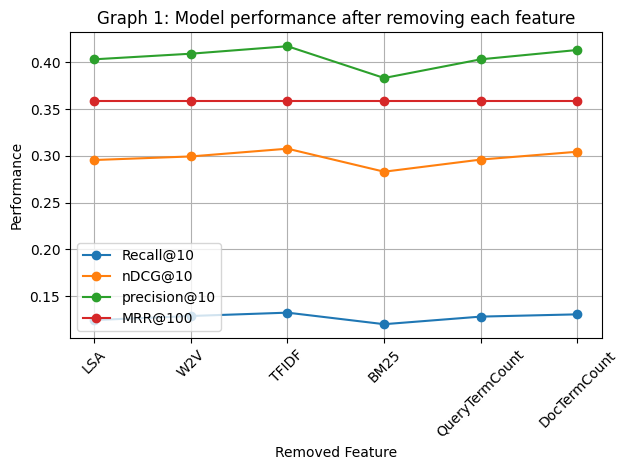

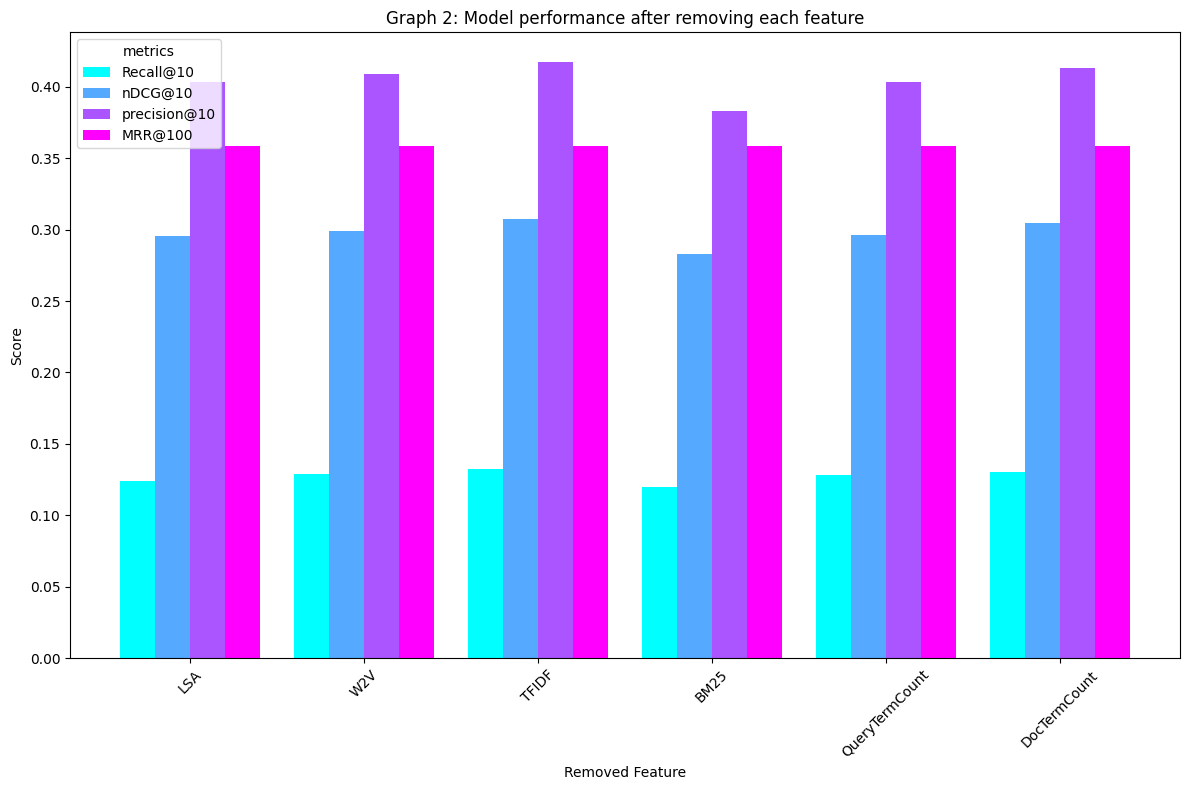

In [81]:
# Note: the plot should be obvious in the submitted notebook
xlabel = 'Removed Feature'
title = 'Model performance after removing each feature'

plot_results_line(result, xlabel, 'Graph 1: ' + title)
plot_results_bar(result, xlabel, 'Graph 2: ' + title)

Some more things we wanted to test to see if the XGBoost model actually works:

In [82]:
feature_names = ['LSA', 'W2V', 'TFIDF', 'BM25', 'QueryTermCount', 'DocTermCount']
features_train = create_features(bm25_rankings_train, tfidf_rankings_train, lsa_rankings_train, w2v_rankings_train, query_terms_count_train, doc_terms_count_train, feature_names)
features_val = create_features(bm25_rankings_val, tfidf_rankings_val, lsa_rankings_val, w2v_rankings_val, query_terms_count_val, doc_terms_count_val, feature_names)

ranker = XGBoostRanker(feature_names=feature_names, params=best_params, n_estimators=1000)
ranker.train(features_train, train_qrel_dict)

preds_train = ranker.predict(features_train)
preds_val = ranker.predict(features_val)

metrics = ['recall_10', 'recall_20', 'ndcg_cut_10', 'P_5', 'P_10', 'P_20', 'mrr_100']
print('VAL')
eval_val = evaluate(validation_qrel_dict, preds_val, metrics)
print('TRAIN')
eval_train = evaluate(train_qrel_dict, preds_train, metrics)

Model trained successfully.
VAL
recall_10: 0.1286 ; recall_20: 0.2155 ; ndcg_cut_10: 0.3064 ; P_5: 0.4320 ; P_10: 0.4113 ; P_20: 0.3583 ; mrr_100: 0.3589
TRAIN
recall_10: 0.7712 ; recall_20: 0.7720 ; ndcg_cut_10: 0.7170 ; P_5: 0.1610 ; P_10: 0.0818 ; P_20: 0.0410 ; mrr_100: 0.0000


In [83]:
feature_names = ['LSA', 'W2V', 'TFIDF', 'BM25', 'QueryTermCount', 'DocTermCount']
features_train = create_features(bm25_rankings_train, tfidf_rankings_train, lsa_rankings_train, w2v_rankings_train, query_terms_count_train, doc_terms_count_train, feature_names)
features_val = create_features(bm25_rankings_val, tfidf_rankings_val, lsa_rankings_val, w2v_rankings_val, query_terms_count_val, doc_terms_count_val, feature_names)

ranker = XGBoostRanker(feature_names=feature_names, params=best_params, n_estimators=1) # n_estimators = 1
ranker.train(features_train, train_qrel_dict)

preds_train = ranker.predict(features_train)
preds_val = ranker.predict(features_val)

metrics = ['recall_10', 'recall_20', 'ndcg_cut_10', 'P_5', 'P_10', 'P_20', 'mrr_100']
print('VAL')
eval_val = evaluate(validation_qrel_dict, preds_val, metrics)
print('TRAIN')
eval_train = evaluate(train_qrel_dict, preds_train, metrics)

Model trained successfully.
VAL
recall_10: 0.1116 ; recall_20: 0.1875 ; ndcg_cut_10: 0.2657 ; P_5: 0.3853 ; P_10: 0.3587 ; P_20: 0.3177 ; mrr_100: 0.3589
TRAIN
recall_10: 0.7393 ; recall_20: 0.7720 ; ndcg_cut_10: 0.5692 ; P_5: 0.1379 ; P_10: 0.0784 ; P_20: 0.0410 ; mrr_100: 0.0000


In [84]:
ranker = XGBoostRanker(feature_names=feature_names, params=None, n_estimators=1000) # params = None
ranker.train(features_train, train_qrel_dict)
preds_train = ranker.predict(features_train)
print('TRAIN')
eval_train = evaluate(train_qrel_dict, preds_train, metrics)

Model trained successfully.
TRAIN
recall_10: 0.7720 ; recall_20: 0.7720 ; ndcg_cut_10: 0.7735 ; P_5: 0.1640 ; P_10: 0.0820 ; P_20: 0.0410 ; mrr_100: 0.0000


In [85]:
feature_names = ['BM25']
features_train = create_features(bm25_rankings_train, tfidf_rankings_train, lsa_rankings_train, w2v_rankings_train, query_terms_count_train, doc_terms_count_train, feature_names)
features_val = create_features(bm25_rankings_val, tfidf_rankings_val, lsa_rankings_val, w2v_rankings_val, query_terms_count_val, doc_terms_count_val, feature_names)

ranker = XGBoostRanker(feature_names=feature_names, params=best_params, n_estimators=1000)
ranker.train(features_train, train_qrel_dict)

preds_train = ranker.predict(features_train)
preds_val = ranker.predict(features_val)

metrics = ['recall_10', 'recall_20', 'ndcg_cut_10', 'P_5', 'P_10', 'P_20', 'mrr_100']
print('VAL')
eval_val = evaluate(validation_qrel_dict, preds_val, metrics)
print('TRAIN')
eval_train = evaluate(train_qrel_dict, preds_train, metrics)

Model trained successfully.
VAL
recall_10: 0.1310 ; recall_20: 0.2316 ; ndcg_cut_10: 0.3218 ; P_5: 0.4440 ; P_10: 0.4213 ; P_20: 0.3900 ; mrr_100: 0.3589
TRAIN
recall_10: 0.7110 ; recall_20: 0.7720 ; ndcg_cut_10: 0.5610 ; P_5: 0.1332 ; P_10: 0.0753 ; P_20: 0.0410 ; mrr_100: 0.0000


In [86]:
feature_names = ['BM25', 'W2V']
features_train = create_features(bm25_rankings_train, tfidf_rankings_train, lsa_rankings_train, w2v_rankings_train, query_terms_count_train, doc_terms_count_train, feature_names)
features_val = create_features(bm25_rankings_val, tfidf_rankings_val, lsa_rankings_val, w2v_rankings_val, query_terms_count_val, doc_terms_count_val, feature_names)

ranker = XGBoostRanker(feature_names=feature_names, params=best_params, n_estimators=1000)
ranker.train(features_train, train_qrel_dict)

preds_train = ranker.predict(features_train)
preds_val = ranker.predict(features_val)

metrics = ['recall_10', 'recall_20', 'ndcg_cut_10', 'P_5', 'P_10', 'P_20', 'mrr_100']
print('VAL')
eval_val = evaluate(validation_qrel_dict, preds_val, metrics)
print('TRAIN')
eval_train = evaluate(train_qrel_dict, preds_train, metrics)

Model trained successfully.
VAL
recall_10: 0.1367 ; recall_20: 0.2286 ; ndcg_cut_10: 0.3255 ; P_5: 0.4573 ; P_10: 0.4193 ; P_20: 0.3797 ; mrr_100: 0.3589
TRAIN
recall_10: 0.7631 ; recall_20: 0.7720 ; ndcg_cut_10: 0.6621 ; P_5: 0.1533 ; P_10: 0.0809 ; P_20: 0.0410 ; mrr_100: 0.0000


Results of the BM25 model itself:

recall_10: 0.1475 ; recall_20: 0.2415 ; ndcg_cut_10: 0.3565 ; P_5: 0.4693 ; P_20: 0.4043 ; mrr_100: 0.5367

**Step 4.2:** Select the best set of features considering the performance of the validations set and submit a run to Codalab based on the performance of the model on the test set. Report the best set of parameters. (2)


In [87]:
# Looking at the plots, this would be the logical best set of features

feature_names = ['LSA', 'W2V', 'BM25', 'QueryTermCount']
features_train = create_features(bm25_rankings_train, tfidf_rankings_train, lsa_rankings_train, w2v_rankings_train, query_terms_count_train, doc_terms_count_train, feature_names)
features_val = create_features(bm25_rankings_val, tfidf_rankings_val, lsa_rankings_val, w2v_rankings_val, query_terms_count_val, doc_terms_count_val, feature_names)
features_test = create_features(bm25_rankings_test, tfidf_rankings_test, lsa_rankings_test, w2v_rankings_test, query_terms_count_test, doc_terms_count_test, feature_names)

ranker = XGBoostRanker(feature_names=feature_names, params=best_params, n_estimators=1000)
ranker.train(features_train, train_qrel_dict)

preds_train = ranker.predict(features_train)
xgb_rankings_val = ranker.predict(features_val)
xgb_rankings_test = ranker.predict(features_test)

metrics = ['recall_10', 'recall_20', 'ndcg_cut_10', 'P_5', 'P_10', 'P_20', 'mrr_100']
print('VAL')
eval_val = evaluate(validation_qrel_dict, preds_val, metrics)
print('TRAIN')
eval_train = evaluate(train_qrel_dict, preds_train, metrics)

# It is quite close between this set, just the BM25 and [BM25, W2V], but we choose this one

Model trained successfully.
VAL
recall_10: 0.1367 ; recall_20: 0.2286 ; ndcg_cut_10: 0.3255 ; P_5: 0.4573 ; P_10: 0.4193 ; P_20: 0.3797 ; mrr_100: 0.3589
TRAIN
recall_10: 0.7676 ; recall_20: 0.7720 ; ndcg_cut_10: 0.6856 ; P_5: 0.1574 ; P_10: 0.0814 ; P_20: 0.0410 ; mrr_100: 0.0000


In [88]:
# Convert the output to the output required for Codalab and submit

valid_output_file = write_ranking_results(xgb_rankings_val, 'submission_validation.text', 'xgb')
test_output_file = write_ranking_results(xgb_rankings_test, 'submission_test.text', 'xgb')
codalab_submission_file = codalab_format('submission_validation.text', 'submission_test.text', studentnumber1, studentnumber2)

Produced file submission_validation.text
Produced file submission_test.text
Produced submission file output\14646161_14622556_codalab_submission.zip


TEST SCORES:

Recall@100: 0.6427

nDCG@10: 0.3357

Precision@10: 0.4430

MRR@10: 0.6388 

MRR@10 (validation set): 0.6042

**Step 4.3:** Run the model for different values of eta, i.e., [0.1, 0.01, 0.001, 0.0001] using the best set of features from the previous part. Plot the performance per each value of eta (x-axis) on the validation set over Recall@10, nDCG@10, Precision@10, and MRR@100 metrics. (8)


In [89]:
result_eta = defaultdict(lambda: defaultdict(float))

feature_names = ['LSA', 'W2V', 'BM25', 'QueryTermCount']

features_train = create_features(bm25_rankings_train, tfidf_rankings_train, lsa_rankings_train, w2v_rankings_train, query_terms_count_train, doc_terms_count_train, feature_names)
features_val = create_features(bm25_rankings_val, tfidf_rankings_val, lsa_rankings_val, w2v_rankings_val, query_terms_count_val, doc_terms_count_val, feature_names)
metrics = ['recall_10', 'recall_20', 'ndcg_cut_10', 'P_5', 'P_10', 'P_20', 'mrr_100']

for eta in [0.1, 0.01, 0.001, 0.0001]:

  # train the XGBoost model,
  # evaluate the performance of model on validation set using pytrec_eval
  # store the result in result_eta
  
  ranker = XGBoostRanker(feature_names=feature_names, params={'eta': eta}, n_estimators=1000)
  ranker.train(features_train, train_qrel_dict)
  predictions_val = ranker.predict(features_val)
  eval = evaluate(validation_qrel_dict, predictions_val, metrics)
  
  result_eta[eta]['Recall@10'] = eval['recall_10']
  result_eta[eta]['nDCG@10'] = eval['ndcg_cut_10']
  result_eta[eta]['precision@10'] = eval['P_10']
  result_eta[eta]['MRR@100'] = eval['mrr_100']

Model trained successfully.
recall_10: 0.1068 ; recall_20: 0.1874 ; ndcg_cut_10: 0.2647 ; P_5: 0.3680 ; P_10: 0.3513 ; P_20: 0.3237 ; mrr_100: 0.3589
Model trained successfully.
recall_10: 0.1267 ; recall_20: 0.2316 ; ndcg_cut_10: 0.3052 ; P_5: 0.4107 ; P_10: 0.4073 ; P_20: 0.3827 ; mrr_100: 0.3589
Model trained successfully.
recall_10: 0.1352 ; recall_20: 0.2352 ; ndcg_cut_10: 0.3233 ; P_5: 0.4360 ; P_10: 0.4247 ; P_20: 0.3910 ; mrr_100: 0.3589
Model trained successfully.
recall_10: 0.1245 ; recall_20: 0.2189 ; ndcg_cut_10: 0.3092 ; P_5: 0.4093 ; P_10: 0.3920 ; P_20: 0.3703 ; mrr_100: 0.3589


**Step 4.4:** Select the best value of the eta parameter considering the performance of the validations set and submit a run to Codalab based on the performance of the model on the test set. Report the best value of eta, together with the best performance on the validation and test set. (2)

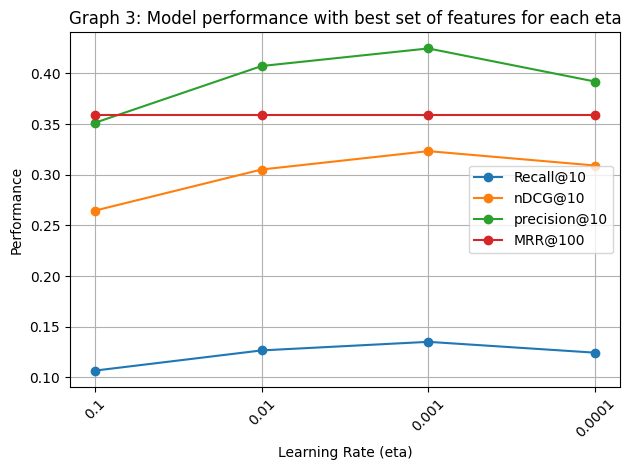

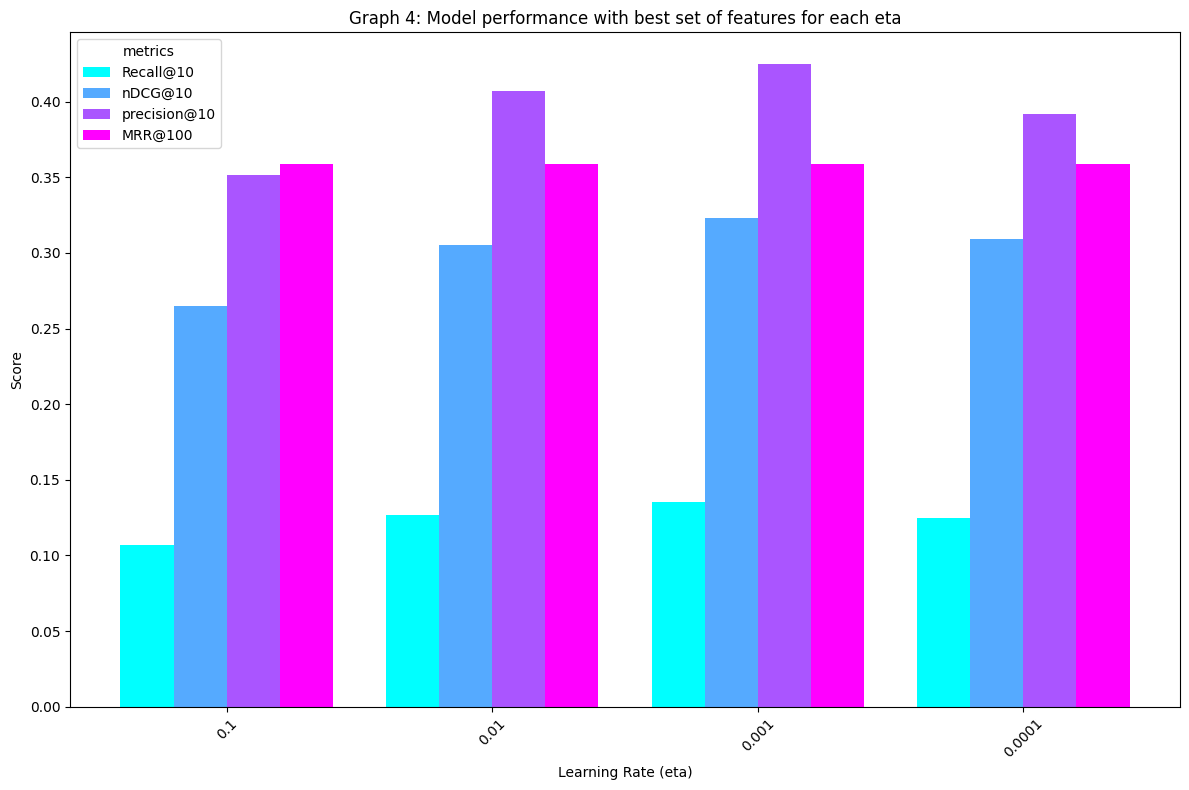

In [90]:
# Plot the performance using each value of eta
# Note: the plot must be clear to read in the submitted notebook
xlabel = 'Learning Rate (eta)'
title = 'Model performance with best set of features for each eta'

plot_results_line(result_eta, xlabel, 'Graph 3: ' + title)
plot_results_bar(result_eta, xlabel, 'Graph 4: ' + title)

The best value for eta based on these graphs is 0.001

In [91]:
# Re-rank top 100 passages of test queries using XGBoost with best set of features and eta
feature_names = ['LSA', 'W2V', 'BM25', 'QueryTermCount']
features_train = create_features(bm25_rankings_train, tfidf_rankings_train, lsa_rankings_train, w2v_rankings_train, query_terms_count_train, doc_terms_count_train, feature_names)
features_val = create_features(bm25_rankings_val, tfidf_rankings_val, lsa_rankings_val, w2v_rankings_val, query_terms_count_val, doc_terms_count_val, feature_names)
features_test = create_features(bm25_rankings_test, tfidf_rankings_test, lsa_rankings_test, w2v_rankings_test, query_terms_count_test, doc_terms_count_test, feature_names)

ranker = XGBoostRanker(feature_names=feature_names, params={'eta': 0.001}, n_estimators=1000)
ranker.train(features_train, train_qrel_dict)

xgb_rankings_val = ranker.predict(features_val)
xgb_rankings_test = ranker.predict(features_test)

Model trained successfully.


The best scores on the validation set:

In [92]:
xgb_val_eval = evaluate(validation_qrel_dict, xgb_rankings_val)

recall_10: 0.1352 ; recall_20: 0.2352 ; ndcg_cut_10: 0.3233 ; P_5: 0.4360 ; P_20: 0.3910 ; mrr_100: 0.3589


We are not going to do more hyperparameter tuning because it takes time and the cross-encoders are way better, so they deserve our full attention

In [93]:
# Convert the output to the output required for Codalab and submit
# Tip: Use the two functions defined on the top of this Notebook.

valid_output_file = write_ranking_results(xgb_rankings_val, 'submission_validation.text', 'xgb')
test_output_file = write_ranking_results(xgb_rankings_test, 'submission_test.text', 'xgb')
codalab_submission_file = codalab_format('submission_validation.text', 'submission_test.text', studentnumber1, studentnumber2)

Produced file submission_validation.text
Produced file submission_test.text
Produced submission file output\14646161_14622556_codalab_submission.zip


We chose the eta of 0.001 because that scores across all metrics better than the other eta values

TEST SCORES:

Recall@100: 0.6427

nDCG@10: 0.3578

Precision@10: 0.4655

MRR@10: 0.6785  

MRR@10 (validation set): 0.5869

		 		

**Step 4.4:** Finally, write a brief report on your experiments in the feature dropping and your findings in the hyperparameter tuning, back it up with arguments, the appropriate results, and graphs. Number these graphs and reference to them in your text. The report should be 300-500 words. (15)

**Note:** You are judged on all the aforementioned points and readability.

In this milestone, we focused on enhancing the ranking model's performance by examining the impact of various features and adjusting hyperparameters to reduce overfitting. Our initial findings suggested that adding more features did not consistently improve performance. Performance metrics on the training set indicated overfitting, prompting us to explore feature selection and regularization techniques.

The features considered included LSA similarity, W2V similarity, TF-IDF score, BM25 score, query term count, and document term count. Observing that training set performance was substantially higher than validation set performance, we noted that recall at 20 and nDCG at 10 decreased by approximately 0.3 on the validation set, while precision at 5 and 10 increased, confirming overfitting. Analysis of feature impact, as shown in Graphs 1 and 2, revealed that LSA and BM25 scores were the most crucial features for model performance. Removing features like TF-IDF and document term count, in fact, slightly improved nDCG and precision on the validation data, indicating they contributed minimal value to ranking quality.

After excluding TF-IDF and document term count and retraining, generalization improved modestly, but overfitting persisted.

We employed a grid search to fine-tune hyperparameters for the XGBoost ranking model, optimizing learning rate, minimum loss reduction, and L1 and L2 regularization terms. The optimal configuration included a learning rate of 0.25, a minimum loss reduction of 0.4, an L1 regularization term of 0.15, and an L2 regularization term of 1.2. While this configuration slightly improved performance, the simpler BM25 model, which actually was even one of the features, still outperformed it overall.

To further mitigate overfitting, we applied early stopping based on validation performance, ceasing training if no improvement was observed after 10 rounds. Although this approach yielded marginal improvements, overfitting remained a challenge. Analysis of learning rates, presented in Graphs 3 and 4, indicated that a learning rate of 0.001 performed best for our chosen feature set when other parameters remained at their default values.

These experiments highlighted the uneven contribution of features to model performance, underscoring the need for deliberate feature selection. Simply increasing feature count did not enhance performance, as certain features, such as document term count and TF-IDF, introduced noise rather than meaningful insights into ranking quality.

# Using pre-trained cross-encoder models (33)


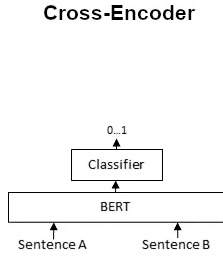

**Background:** A pre-trained cross-encoder is a model that has been trained to understand the similarity and relevance between pairs of inputs, often for tasks like question-answering and ranking. It takes two inputs, processes them together in a single pass (rather than independently), and outputs a score representing how related or similar the inputs are. Pre-training helps the model learn general patterns, and it can be fine-tuned on specific tasks for better performance in areas like natural language processing. The training is done on an encoder-only language model, such as BERT. The encoder-only language models take text tokens as input and produce an embedding of the whole text in a high-dimensional dense space. A cross-encoder model adds a classification layer on top of the language model (e.g., BERT) that predicts the similarity of the two given inputs.

In this part of the project, you will gain experience using these models off-the-shelf and witness their capabilities in capturing semantic and complex similarities that simpler models fail to capture.

If you want to read more about BERT and pre-trained cross-encoders you can see these articles: [BERT Explained](https://medium.com/@samia.khalid/bert-explained-a-complete-guide-with-theory-and-tutorial-3ac9ebc8fa7c), [Cross-Encoders](https://osanseviero.github.io/hackerllama/blog/posts/sentence_embeddings2/)

**Step 5:** Load the pre-trained cross-encoder model ``cross-encoder/ms-marco-MiniLM-L-6-v2`` from the ``sentence_transformers`` library. Compute the similarity of each query and each of the top 100 passages for validation and test queries from Step 1 using the pre-trained cross-encoder model. Use the queries and top 100 passages based on BM25 score for re-ranking. Report the performance on test and validation set queries. (15)

In [94]:
from sentence_transformers import CrossEncoder
reranker = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2', device='cuda')


In [95]:
# Get top 100 passages per query in validation set based on BM25 score
# Compute the similarity of query with each of the top 100 passages in validation set
# Report the performance on validation set

def cross_encoder(bm25_rankings, queries_dict, collection_dict, output_file, reranker):
    query_doc_pairs_text = []
    query_doc_pairs_ids = []
    
    for query_id, doc_dict in bm25_rankings.items():
        assert len(doc_dict) in [20, 100, 200, 2000], f"Query {query_id} has {len(doc_dict)} documents, expected 20 or 100."
        query_text = queries_dict.get(query_id)
        for doc_id in doc_dict.keys():
            doc_text = collection_dict.get(doc_id)
            query_doc_pairs_text.append((query_text, doc_text))
            query_doc_pairs_ids.append((query_id, doc_id))

    scores = reranker.predict(query_doc_pairs_text)

    cross_encoder_rankings = defaultdict(dict)
    for (query_id, doc_id), score in zip(query_doc_pairs_ids, scores):
        cross_encoder_rankings[query_id][doc_id] = float(score)
        
    for query_id in cross_encoder_rankings:
        sorted_docs = sorted(cross_encoder_rankings[query_id].items(), key=lambda item: item[1], reverse=True)
        cross_encoder_rankings[query_id] = dict(sorted_docs)
        
    write_rankings_to_file(cross_encoder_rankings, output_file)

    return cross_encoder_rankings

In [96]:
# Get top 100 passages per query in validation set based on BM25 score
# Compute the similarity of query with each of the top 100 passages in validation set
# Report the performance on validation set

try:
    cross_encoder_val = read_file_to_dict('results/cross_encoder_val.txt')
except:
    cross_encoder_val = cross_encoder(bm25_rankings_val, validation_queries_dict, collection_dict, 'cross_encoder_val.txt', reranker)
    

for query in cross_encoder_val:
    assert len(cross_encoder_val[query]) == 100, f"doc_count of {query} is {len(cross_encoder_val[query])}"
    
for query_id in bm25_rankings_val.keys():
        bm25_doc_ids = set(bm25_rankings_val[query_id].keys())
        cross_doc_ids = set(cross_encoder_val[query_id].keys())

        assert bm25_doc_ids == cross_doc_ids, f"Document IDs mismatch for query '{query_id}'"
        

cross_val_eval = evaluate(validation_qrel_dict, cross_encoder_val)

recall_10: 0.1831 ; recall_20: 0.3048 ; ndcg_cut_10: 0.4641 ; P_5: 0.5840 ; P_20: 0.4903 ; mrr_100: 0.6242


In [97]:
# Get top 100 passages per query in test set based on BM25 score
# Compute the similarity of query with each of the top 100 passages in test set
# Convert the result to the format required for Codalab
# submit a run to Codalab

try:
    cross_encoder_test = read_file_to_dict('results/cross_encoder_test.txt')
except:
    cross_encoder_test = cross_encoder(bm25_rankings_test, test_queries_dict, collection_dict, 'cross_encoder_test.txt', reranker)
    

for query in cross_encoder_test:
    assert len(cross_encoder_test[query]) == 100, f"doc_count of {query} is {len(cross_encoder_test[query])}"
    
for query_id in bm25_rankings_test.keys():
        bm25_doc_ids = set(bm25_rankings_test[query_id].keys())
        cross_doc_ids = set(cross_encoder_test[query_id].keys())

        assert bm25_doc_ids == cross_doc_ids, f"Document IDs mismatch for query '{query_id}'"
        

valid_output_file = write_ranking_results(cross_encoder_val, 'submission_validation.text', 'cross_encoder')
test_output_file = write_ranking_results(cross_encoder_test, 'submission_test.text', 'cross_encoder')
codalab_submission_file = codalab_format('submission_validation.text', 'submission_test.text', studentnumber1, studentnumber2)

Produced file submission_validation.text
Produced file submission_test.text
Produced submission file output\14646161_14622556_codalab_submission.zip


TEST SCORES:

Recall@100: 0.6427

nDCG@10: 0.4494

Precision@10: 0.5555

MRR@10: 0.7645 

MRR@10 (validation set): 0.7267	 	

**Step 6:** Can you think of new features or other re-ranker models to improve the results further? Provide a detailed explanation of the model or features that you propose, implement them and report the performance on validation and test sets.(18)

***Using another cross encoder***

In [98]:
reranker_new = CrossEncoder('cross-encoder/ms-marco-TinyBERT-L-2-v2', device='cuda')

In [99]:
try:
    cross_encoder_val = read_file_to_dict('results/cross_encoder_val.txt')
except:
    cross_encoder_val = cross_encoder(bm25_rankings_val, validation_queries_dict, collection_dict, 'cross_encoder_val.txt', reranker_new)
    

for query in cross_encoder_val:
    assert len(cross_encoder_val[query]) == 100, f"doc_count of {query} is {len(cross_encoder_val[query])}"
    
for query_id in bm25_rankings_val.keys():
        bm25_doc_ids = set(bm25_rankings_val[query_id].keys())
        cross_doc_ids = set(cross_encoder_val[query_id].keys())

        assert bm25_doc_ids == cross_doc_ids, f"Document IDs mismatch for query '{query_id}'"
        

cross_val_eval = evaluate(validation_qrel_dict, cross_encoder_val)

recall_10: 0.1831 ; recall_20: 0.3048 ; ndcg_cut_10: 0.4641 ; P_5: 0.5840 ; P_20: 0.4903 ; mrr_100: 0.6242


***We tried the following cross-encoders (before finetuning):***

SCORES VAL

ms-marco-MiniLM-L-6-v2: recall_10: 0.1831 ; recall_20: 0.3048 ; ndcg_cut_10: 0.4641 ; P_5: 0.5840 ; P_20: 0.4903 ; mrr_100: 0.6242

ms-marco-MiniLM-L-12-v2: recall_10: 0.1740 ; recall_20: 0.3090 ; ndcg_cut_10: 0.4451 ; P_5: 0.5733 ; P_20: 0.4923 ; mrr_100: 0.6255 (slow)

ms-marco-TinyBERT-L-2-v2: recall_10: 0.1581 ; recall_20: 0.2716 ; ndcg_cut_10: 0.3873 ; P_5: 0.5133 ; P_20: 0.4363 ; mrr_100: 0.5563 (fast)

stsb-roberta-base: recall_10: 0.0693 ; recall_20: 0.1569 ; ndcg_cut_10: 0.1635 ; P_5: 0.2307 ; P_20: 0.2640 ; mrr_100: 0.2928 (slow)

---


We will stick to the 'ms-marco-MiniLM-L-6-v2', because it arguably has the best scores and it is twice as fast as the L12

***Using a BERT model***

In [100]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# Initialize model and tokenizer
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'The device being used is {device}')
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=1).to(device)

def bert_reranker(bm25_rankings, queries_dict, output_file, batch_size=16):
    query_doc_pairs_text = []
    query_doc_pairs_ids = []
    
    # Prepare all query-document pairs
    for query_id, doc_dict in bm25_rankings.items():
        assert len(doc_dict) in [20, 100, 200], f"Query {query_id} has {len(doc_dict)} documents, expected 20 or 100."
        query_text = queries_dict.get(query_id)
        for doc_id in doc_dict.keys():
            doc_text = collection_dict.get(doc_id)
            query_doc_pairs_text.append((query_text, doc_text))
            query_doc_pairs_ids.append((query_id, doc_id))
    
    # Run inference in batches
    scores = []
    for i in range(0, len(query_doc_pairs_text), batch_size):
        batch_pairs = query_doc_pairs_text[i:i + batch_size]
        inputs = tokenizer(
            [f"{query} [SEP] {doc}" for query, doc in batch_pairs],
            padding=True,
            truncation=True,
            return_tensors="pt"
        ).to(device)

        with torch.no_grad():
            outputs = model(**inputs)
            batch_scores = outputs.logits.squeeze(-1).cpu().numpy()
            scores.extend(batch_scores)

    # Build rankings
    cross_encoder_rankings = defaultdict(dict)
    for (query_id, doc_id), score in zip(query_doc_pairs_ids, scores):
        cross_encoder_rankings[query_id][doc_id] = float(score)

    # Sort scores for each query
    for query_id in cross_encoder_rankings:
        sorted_docs = sorted(cross_encoder_rankings[query_id].items(), key=lambda item: item[1], reverse=True)
        cross_encoder_rankings[query_id] = dict(sorted_docs)

    # Write results to file
    write_rankings_to_file(cross_encoder_rankings, output_file)

    return cross_encoder_rankings


The device being used is cuda


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\abedi\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\module.py:1150: UserWarning: expandable_segments not supported on this platform (Triggered internally at ..\c10/cuda/CUDAAllocatorConfig.h:30.)
  return t.to(device, dtype if t.is_floating_point() or t.is_complex() else None, non_blocking)


In [101]:
try:
    bert_val = read_file_to_dict('results/bert_val.txt')
except:
    bert_val = bert_reranker(bm25_rankings_val, validation_queries_dict, 'bert_val.txt')
    

for query in bert_val:
    assert len(bert_val[query]) == 100, f"doc_count of {query} is {len(bert_val[query])}"
    
for query_id in bm25_rankings_val.keys():
        bm25_doc_ids = set(bm25_rankings_val[query_id].keys())
        bert_doc_ids = set(bert_val[query_id].keys())

        assert bm25_doc_ids == bert_doc_ids, f"Document IDs mismatch for query '{query_id}'"
        
bert_eval = evaluate(validation_qrel_dict, bert_val)

recall_10: 0.0587 ; recall_20: 0.1240 ; ndcg_cut_10: 0.1245 ; P_5: 0.1800 ; P_20: 0.2117 ; mrr_100: 0.2225


Cross encoders are usually better for query-document ranking than BERT models (bi-encoders) and although finetuning could make it better, we don't think that it will outperform the cross encoder and thus it is not worth out time.

***By training the cross-encoder to our training data***

In [102]:
try:
    reranker_trained = CrossEncoder('cross_encoder_trained_preprocessed', device='cuda')
except:
    train_samples = []
    for query_id, doc_scores in bm25_rankings_train.items():
        query_text = train_queries_dict[query_id]
        for doc_id in doc_scores.keys():
            doc_text = collection_dict[doc_id]
            relevance_score = train_qrel_dict.get(query_id, {}).get(doc_id, 0)
            train_samples.append(InputExample(texts=[query_text, doc_text], label=relevance_score))

    # Initialize the CrossEncoder model
    reranker = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2', device='cuda')
    
    # Create a DataLoader
    train_dataloader = DataLoader(train_samples, shuffle=True, batch_size=16)

    # Train the model
    reranker.fit(train_dataloader=train_dataloader, epochs=1, warmup_steps=100)

    reranker.save('cross_encoder_trained')
    print("Model manually saved to 'cross_encoder_trained'")

    reranker_trained = CrossEncoder('cross_encoder_trained', device='cuda')

In [103]:
try:
    ce_trained_val = read_file_to_dict('results/ce_trained_val.txt')
except:
    ce_trained_val = cross_encoder(bm25_rankings_val, validation_queries_dict, collection_dict, 'ce_trained_val.txt', reranker_trained)
    

for query in ce_trained_val:
    assert len(ce_trained_val[query]) == 100, f"doc_count of {query} is {len(ce_trained_val[query])}"
    
for query_id in bm25_rankings_val.keys():
        bm25_doc_ids = set(bm25_rankings_val[query_id].keys())
        ce_trained_doc_ids = set(ce_trained_val[query_id].keys())

        assert bm25_doc_ids == ce_trained_doc_ids, f"Document IDs mismatch for query '{query_id}'"
        

cross_val_eval = evaluate(validation_qrel_dict, ce_trained_val)

recall_10: 0.1716 ; recall_20: 0.2837 ; ndcg_cut_10: 0.4305 ; P_5: 0.5787 ; P_20: 0.4553 ; mrr_100: 0.6105


In [104]:
try:
    ce_trained_test = read_file_to_dict('results/ce_trained_test.txt')
except:
    ce_trained_test = cross_encoder(bm25_rankings_test, test_queries_dict, collection_dict, 'ce_trained_test.txt', reranker_trained)
    

for query in ce_trained_test:
    assert len(ce_trained_test[query]) == 100, f"doc_count of {query} is {len(ce_trained_test[query])}"
    
for query_id in bm25_rankings_test.keys():
        bm25_doc_ids = set(bm25_rankings_test[query_id].keys())
        ce_trained_doc_ids = set(ce_trained_test[query_id].keys())

        assert bm25_doc_ids == ce_trained_doc_ids, f"Document IDs mismatch for query '{query_id}'"
        

valid_output_file = write_ranking_results(ce_trained_val, 'submission_validation.text', 'cross_encoder')
test_output_file = write_ranking_results(ce_trained_test, 'submission_test.text', 'cross_encoder')
codalab_submission_file = codalab_format('submission_validation.text', 'submission_test.text', studentnumber1, studentnumber2)

Produced file submission_validation.text
Produced file submission_test.text
Produced submission file output\14646161_14622556_codalab_submission.zip


***Return more using BM25***

The recall@100 can never be better than that of the original ranker (BM25), because we only returned 100 documents per query with that one before.

Now we are going to increase that and we are also going to make the training set bigger.

In [105]:
try:
    bm25_rankings_val_200 = read_file_to_dict('results/bm25_val_200.txt')
    bm25_rankings_test_200 = read_file_to_dict('results/bm25_test_200.txt')
except:
    bm25_rankings_val_200 = bm25(validation_queries_dict, 200, 'bm25_val_200.txt')
    bm25_rankings_test_200 = bm25(test_queries_dict, 200, 'bm25_test_200.txt')

***Trying without pre-processing***

Because the cross-encoders are made for full texts, they could be better if the queries and documents are full sentences instead of loose words.

In [106]:
train_queries_dict_raw = load_queries_dict('data/training_queries.tsv')
test_queries_dict_raw = load_queries_dict('data/test_queries.tsv')
validation_queries_dict_raw = load_queries_dict('data/validation_queries.tsv')

collection_dict_raw = load_collection_dict('data/collection.jsonl')

In [107]:
reranker = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2', device='cuda')

In [108]:
try:
    ce_raw_val = read_file_to_dict('results/ce_raw_val.txt')
except:
    ce_raw_val = cross_encoder(bm25_rankings_val_200, validation_queries_dict_raw, collection_dict_raw, 'ce_raw_val.txt', reranker)
    

for query in ce_raw_val:
    assert len(ce_raw_val[query]) == 200, f"doc_count of {query} is {len(ce_raw_val[query])}"
    
for query_id in bm25_rankings_val_200.keys():
        bm25_doc_ids = set(bm25_rankings_val_200[query_id].keys())
        cross_doc_ids = set(ce_raw_val[query_id].keys())

        assert bm25_doc_ids == cross_doc_ids, f"Document IDs mismatch for query '{query_id}'"
        

ce_raw_val_eval = evaluate(validation_qrel_dict, ce_raw_val)

recall_10: 0.2076 ; recall_20: 0.3409 ; ndcg_cut_10: 0.5337 ; P_5: 0.6493 ; P_20: 0.5310 ; mrr_100: 0.7085


The scores actually increased a lot!

Now we are going to train it on our (raw and bigger) training dataset

In [109]:
try:
    ce_trained_raw = CrossEncoder('ce_trained_raw_2', device='cuda')
except (FileNotFoundError, OSError):
    train_samples = []
    for query_id, doc_scores in bm25_rankings_train.items():
        query_text = train_queries_dict_raw[query_id]
        for doc_id in doc_scores.keys():
            doc_text = collection_dict_raw[doc_id]
            relevance_score = train_qrel_dict.get(query_id, {}).get(doc_id, 0)
            train_samples.append(InputExample(texts=[query_text, doc_text], label=relevance_score))

    reranker = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2', device='cuda')
    
    train_dataset = SentenceLabelDataset(train_samples)
    train_dataloader = DataLoader(train_dataset, batch_size=16)

    # Train the model with more epochs and a custom learning rate
    reranker.fit(train_dataloader=train_dataloader, epochs=3, warmup_steps=20, optimizer_params={'lr': 5e-5})

    reranker.save('ce_trained_raw_2')
    print("Model manually saved to 'ce_trained_raw_2'")

    # Load the trained model for evaluation
    ce_trained_raw = CrossEncoder('ce_trained_raw_2', device='cuda')

In [112]:
try:
    ce_trained_raw_val = read_file_to_dict('results/ce_trained_raw_val.txt')
except:
    ce_trained_raw_val = cross_encoder(bm25_rankings_val_200, validation_queries_dict_raw, collection_dict_raw, 'ce_trained_raw_val.txt', ce_trained_raw)
    

for query in ce_trained_raw_val:
    assert len(ce_trained_raw_val[query]) == 200, f"doc_count of {query} is {len(ce_trained_raw_val[query])}"
    
for query_id in bm25_rankings_val_200.keys():
        bm25_doc_ids = set(bm25_rankings_val_200[query_id].keys())
        ce_trained_doc_ids = set(ce_trained_raw_val[query_id].keys())

        assert bm25_doc_ids == ce_trained_doc_ids, f"Document IDs mismatch for query '{query_id}'"
        
cross_val_eval = evaluate(validation_qrel_dict, ce_trained_raw_val)

recall_10: 0.1688 ; recall_20: 0.2724 ; ndcg_cut_10: 0.4193 ; P_5: 0.5720 ; P_20: 0.4383 ; mrr_100: 0.5755


The model once again became worse after training. We are going to use the untrained model to rank the validation and test sets for the top 2000 from the BM25 to increase the recall even further.

In [113]:
try:
    bm25_rankings_val_2000 = read_file_to_dict('results/bm25_val_2000.txt')
    bm25_rankings_test_2000 = read_file_to_dict('results/bm25_test_2000.txt')
except:
    bm25_rankings_val_2000 = bm25(validation_queries_dict, 1000, 'bm25_val_2000.txt')
    bm25_rankings_test_2000 = bm25(test_queries_dict, 1000, 'bm25_test_2000.txt')

In [114]:
try:
    ce_all_val = read_file_to_dict('results/ce_all_val.txt')
except:
    ce_all_val = cross_encoder(bm25_rankings_val_2000, validation_queries_dict_raw, collection_dict_raw, 'ce_all_val.txt', reranker)
    

for query in ce_all_val:
    assert len(ce_all_val[query]) == 2000, f"doc_count of {query} is {len(ce_all_val[query])}"
    
for query_id in bm25_rankings_val_2000.keys():
        bm25_doc_ids = set(bm25_rankings_val_2000[query_id].keys())
        ce_trained_doc_ids = set(ce_all_val[query_id].keys())

        assert bm25_doc_ids == ce_trained_doc_ids, f"Document IDs mismatch for query '{query_id}'"
        
ce_all_eval = evaluate(validation_qrel_dict, ce_all_val)

recall_10: 0.2128 ; recall_20: 0.3481 ; ndcg_cut_10: 0.5431 ; P_5: 0.6533 ; P_20: 0.5410 ; mrr_100: 0.7162


In [115]:
metrics = ['recall_10', 'recall_100', 'P_20', 'ndcg_cut_10', 'mrr_100']
print('Top 200')
ce_raw_eval = evaluate(validation_qrel_dict, ce_raw_val, metrics)
print('Top 2000')
ce_all_eval = evaluate(validation_qrel_dict, ce_all_val, metrics)

Top 200
recall_10: 0.2076 ; recall_100: 0.7123 ; P_20: 0.5310 ; ndcg_cut_10: 0.5337 ; mrr_100: 0.7085
Top 2000
recall_10: 0.2128 ; recall_100: 0.7681 ; P_20: 0.5410 ; ndcg_cut_10: 0.5431 ; mrr_100: 0.7162


The recall is a lot better and the rest is a bit better. Maybe a higher top_n for the BM25 would have even been possible, altough it would have taken even longer.

**Our best model**

Not fine-tuned, not pre-processed, on top 2000 from the BM25 rankings

In [116]:
try:
    ce_all_test = read_file_to_dict('results/ce_all_test.txt')
except:
    ce_all_test = cross_encoder(bm25_rankings_test_2000, test_queries_dict_raw, collection_dict_raw, 'ce_all_test.txt', reranker)
    

for query in ce_all_test:
    assert len(ce_all_test[query]) == 2000, f"doc_count of {query} is {len(ce_all_test[query])}"
    
for query_id in bm25_rankings_test_2000.keys():
        bm25_doc_ids = set(bm25_rankings_test_2000[query_id].keys())
        cross_doc_ids = set(ce_all_test[query_id].keys())

        assert bm25_doc_ids == cross_doc_ids, f"Document IDs mismatch for query '{query_id}'"
        

valid_output_file = write_ranking_results(ce_all_val, 'submission_validation.text', 'cross_encoder')
test_output_file = write_ranking_results(ce_all_test, 'submission_test.text', 'cross_encoder')
codalab_submission_file = codalab_format('submission_validation.text', 'submission_test.text', studentnumber1, studentnumber2)

Produced file submission_validation.text
Produced file submission_test.text
Produced submission file output\14646161_14622556_codalab_submission.zip


TEST SCORES:

Recall@100: 0.7852 (2)

nDCG@10: 0.5576 (3)

Precision@10: 0.6575 (3)

MRR@10: 0.8604 (2)

MRR@10 (validation set): 0.8047 (3)

**Explaining the models:**

The bi-encoder model processes queries and documents independently, enabling all embeddings to be computed in a single forward pass. This approach allows pre-computation and storage of embeddings for all documents, which significantly reduces computation time during ranking. The bi-encoder can handle multiple queries and documents simultaneously, making it efficient and advantageous for handling large datasets.

However, while bi-encoders provide computational efficiency, cross-encoders tend to perform better in terms of ranking accuracy, although at a higher computational cost. This aligns with the general consensus that, for re-ranking tasks, cross-encoders often outperform bi-encoders despite being slower. We experimented with multiple cross-encoder models from the Hugging Face repository, selecting the L6 model as it yielded the best results in our tests.

Attempts to fine-tune the cross-encoder did not yield performance improvements. Instead, removing all pre-processing from the queries and documents, and increasing the number of documents from the BM25 rankings used for cross-encoder input, enhanced model performance. Increasing the number of documents led to higher recall, as the initial top-100 from BM25 rankings did not cover all relevant items. Furthermore, omitting pre-processing likely benefited the cross-encoder, as it was not trained on stemmed or filtered text but rather on full, natural sentences.

As of this writing, our approach ranks within the top three (under the name "AbeDijkstra"). While this is a strong position, successful fine-tuning of the cross-encoder or even the XGBoostRanker model could have given us first place.

**Potential Future Improvements**

In future iterations, models such as ChatGPT could be tested as potential re-ranking solutions by prompting for query-document similarity scores. However, this method might be time-intensive and costly, as ChatGPT API costs increase with the token count. Furthermore, ChatGPT is not specialized for information retrieval (IR) re-ranking, and it is uncertain whether it would surpass cross-encoder performance.

Another approach might involve integrating the cross-encoder’s ranking outputs as a feature in an LTR (XGBoostRanker) model or by applying a weighted average of normalized scores. However, prior experiments showed that XGBoostRanker did not outperform individual features; in fact, it occasionally underperformed compared to BM25 alone, even when BM25 was incorporated as a feature. Moreover, the cross-encoder itself likely utilizes a form of LTR model, possibly with similar feature sets.

The most promising area for improvement remains fine-tuning the cross-encoder with domain-specific data. Although our initial fine-tuning attempts did not yield the expected performance gains for either the XGBoostRanker or the cross-encoder, further exploration could identify the cause. Potential issues include implementation errors, limitations in training data quality, or that these models may not adapt well to training with a single binary relevance score per query-document pair. Addressing these factors could enhance model adaptability and overall ranking accuracy.

**Conclusion:**

This project provided a rewarding experience, combining practical challenges with a competitive element that complemented theoretical learning. Initially, we encountered some difficulty in working with Elasticsearch, but through hands-on experimentation, we developed a strong grasp of its implementation and functionality.

The project facilitated skill development in data handling, database management, and applying methods in information retrieval. Importantly, it encouraged us to devise independent strategies for model improvement, offering substantial practical experience and fostering creativity.

Our approach reinforced the idea that active experimentation is one of the most effective learning methods, especially when supported by foundational knowledge, as provided in the project materials.

The main challenges we encountered included feeling pressed for time due to the relatively close project deadlines (perhaps an earlier start would help) and some initial uncertainty regarding requirements, particularly in Milestone 1. Additionally, setting up and becoming proficient with Elasticsearch was initially time-consuming.

Overall, this project was both challenging and enriching, equipping us with valuable skills and insights in information retrieval and model optimization.